# 0. Basics

## 0.0. Imports

In [1]:
import primod
import imod
from imod import msw
from imod import mf6

In [2]:
import importlib.metadata as md, json, pathlib, imod, primod
from imod.mf6 import GroundwaterFlowModel as GWF

print("imod:", md.version("imod"))
print("primod path:", primod.__file__)
du = next(p for p in md.distribution("primod").files if p.name=="direct_url.json")
print("primod commit:", json.loads(pathlib.Path(md.distribution("primod").locate_file(du)).read_text())["vcs_info"]["commit_id"])
print("has get_diskey:", hasattr(GWF, "get_diskey"))

imod: 1.0.0rc7
primod path: g:\.pixi\envs\default\Lib\site-packages\primod\__init__.py
primod commit: f2628433d07087f867c36219dbbe1c86f9778bbb
has get_diskey: True


In [118]:
import importlib as IL
IL.reload(primod)
IL.reload(imod)

<module 'imod' from 'g:\\.pixi\\envs\\default\\Lib\\site-packages\\imod\\__init__.py'>

In [4]:
import os
from os import listdir as LD, makedirs as MDs
from os.path import join as PJ, basename as PBN, dirname as PDN, exists as PE
import shutil as sh
import pandas as pd
from datetime import datetime as DT
import matplotlib.pyplot as plt
from pathlib import Path
import re

In [5]:
import WS_Mdl.utils as U
import WS_Mdl.utils_imod as UIM
import WS_Mdl.calcs as C
import WS_Mdl.geo as G
from WS_Mdl.utils import bold, style_reset

In [123]:
import importlib as IL
IL.reload(U)
IL.reload(UIM)
IL.reload(G)

<module 'WS_Mdl.geo' from 'G:\\code\\WS_Mdl\\geo.py'>

In [7]:
# Import sfrmaker and other necessary packages for SFR network creation
import sfrmaker as sfr
import geopandas as gpd
import numpy as np
import xarray as xr
from shapely.geometry import LineString, MultiLineString, box
from shapely.ops import linemerge

In [8]:
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

In [9]:
import primod
import imod
from imod import msw
from imod import mf6

In [10]:
IL.reload(primod)
IL.reload(imod)

<module 'imod' from 'g:\\.pixi\\envs\\default\\Lib\\site-packages\\imod\\__init__.py'>

In [11]:
import DRN_SFR_match
from DRN_SFR_match import match_cells_to_SFR
import w_MVR
from w_MVR import w_MVR

## 0.1. Options

In [12]:
Pa_GPkg_1ry = U.Pa_WS + r'\models\NBr\PrP\SFR\BrabantseDelta\BrabantseDelta_main_split_Cols_trimmed.gpkg' 
Pa_GPkg_1ry_untrimmed = U.Pa_WS + r'\models\NBr\PrP\SFR\BrabantseDelta\WBD_SW_NW_1ry.gpkg' 
Pa_GPkg = U.Pa_WS + r"\models\NBr\PrP\SFR\BrabantseDelta\BrabantseDelta_detailed_split_Cols_trimmed.gpkg"
detailed = 'hydroobject'
primary = 'LEGGER_VASTGESTELD_WATERLOOP_CATEGORIE_A'
Pa_GPkg_untrimmed = U.Pa_WS + r"\models\NBr\PrP\SFR\BrabantseDelta\acceptatiedatabase.gdb"

In [13]:
MdlN = 'NBr37'

In [14]:
U.set_verbose(False)

In [15]:
# Load paths and variables from PRJ & INI
d_Pa = U.get_MdlN_Pa(MdlN)
Pa_PRJ = d_Pa['PRJ']
Dir_PRJ = PDN(Pa_PRJ)
d_INI = U.INI_to_d(d_Pa['INI'])
Xmin, Ymin, Xmax, Ymax, cellsize, N_R, N_C = U.Mdl_Dmns_from_INI(d_Pa['INI'])
SP_date_1st, SP_date_last = [DT.strftime(DT.strptime(d_INI[f'{i}'], '%Y%m%d'), '%Y-%m-%d') for i in ['SDATE', 'EDATE']]
dx = dy = float(d_INI['CELLSIZE'])

In [16]:
U.Mdl_Dmns_from_INI(d_Pa['INI'])

(113100.0, 387600.0, 125100.0, 396200.0, 25.0, 344, 480)

In [202]:
l_X_Y_Cols = ['Xstart', 'Ystart', 'Xend', 'Yend']

# 1. Load Model Ins

## 1.0. Load PRJ

In [17]:
PRJ_, PRJ_OBS = UIM.o_PRJ_with_OBS(Pa_PRJ)

In [18]:
PRJ, period_data = PRJ_[0], PRJ_[1]

## 1.1. Load DIS and limit to Mdl Aa

In [19]:
PRJ_regrid = UIM.regrid_PRJ(PRJ, MdlN)

In [20]:
BND = PRJ_regrid['bnd']['ibound']

In [21]:
# Set outer boundaries to -1 (for CHD)

# Get the coordinate indices for boundaries
y_coords = BND.y
x_coords = BND.x
first_y = y_coords.isel(y=0)  # First y coordinate
last_y = y_coords.isel(y=-1)  # Last y coordinate  
first_x = x_coords.isel(x=0)  # First x coordinate
last_x = x_coords.isel(x=-1)  # Last x coordinate

# Set boundary values using .loc indexing
BND.loc[:, first_y, :] = -1  # Top row (all layers, first y, all x)
BND.loc[:, last_y, :] = -1   # Bottom row (all layers, last y, all x)
BND.loc[:, :, first_x] = -1  # Left column (all layers, all y, first x)  
BND.loc[:, :, last_x] = -1   # Right column (all layers, all y, last x)

print("✅ Boundary conditions set successfully!")

✅ Boundary conditions set successfully!


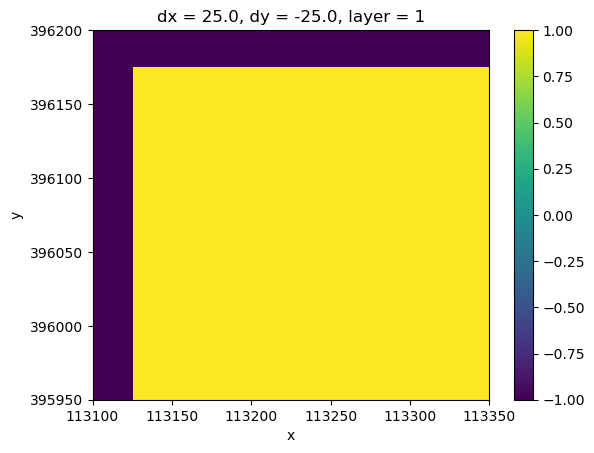

In [22]:
BND.isel(layer=0, x=range(0,10), y=range(0,10)).plot.imshow(cmap='viridis')

## 1.2. Load MF6 Mdl

In [23]:
times = pd.date_range(SP_date_1st, SP_date_last, freq='D')

Using original PRJ to load MF6 Mdl gives warnings (and it's very slow). Thus, well use the regridded PRJ, which is much faster. It can be further sped up by multi-processing, but this is not implemented yet.

In [24]:
Sim_MF6 = mf6.Modflow6Simulation.from_imod5_data(PRJ_regrid, period_data, times)

In [25]:
MF6_Mdl = Sim_MF6['imported_model']

In [26]:
MF6_Mdl["oc"] = mf6.OutputControl(save_head="last", save_budget="last")
Sim_MF6["ims"] = UIM.mf6_solution_moderate_settings() # Mimic iMOD5's "Moderate" settings

In [27]:
MF6_DIS = MF6_Mdl["dis"]  # This gets the OLD 100m grid

## 1.3. Load MSW

### 1.3.0. Fix mete_grid.inp relative paths

In [28]:
# Replace the mete_grid.inp path in the PRJ_MSW_for_MSW dictionary
PRJ['extra']['paths'][2][0] = UIM.mete_grid_Cvt_to_AbsPa(Pa_PRJ, PRJ_regrid)

Created corrected mete_grid.inp: G:\models\NBr\In\CAP\mete_grid\NBr1\temp\mete_grid.inp


### 1.3.2. Finally load MSW Sim

In [29]:
# Create the MetaSwap model
PRJ_MSW = {'cap': PRJ_regrid.copy()['cap'], 'extra': PRJ_regrid.copy()['extra']}
MSW_Mdl = msw.MetaSwapModel.from_imod5_data(PRJ_MSW, MF6_DIS, times)
print("🟢 - MetaSwap model loaded successfully!")

🟢 - MetaSwap model loaded successfully!


## 1.4. Connect MF6 to MetaSWAP

### 1.4.1. Clip models

In [30]:
Sim_MF6_AoI = Sim_MF6.clip_box(x_min=Xmin, x_max=Xmax, y_min=Ymin, y_max=Ymax)
MF6_Mdl_AoI = Sim_MF6_AoI['imported_model']

In [31]:
MSW_Mdl_AoI = MSW_Mdl.clip_box(x_min=Xmin, x_max=Xmax, y_min=Ymin, y_max=Ymax)

In [32]:
print(f"MF6 Model AoI DIS shape: {MF6_Mdl_AoI['dis'].dataset.sizes}")
print(f"MSW Model AoI grid shape: {MSW_Mdl_AoI['grid'].dataset.sizes}")
print("✅ Both models successfully clipped to Area of Interest with compatible discretization!")

MF6 Model AoI DIS shape: Frozen({'layer': 37, 'y': 344, 'x': 480})
MSW Model AoI grid shape: Frozen({'x': 480, 'y': 344, 'subunit': 2})
✅ Both models successfully clipped to Area of Interest with compatible discretization!


## 1.5. Load & Cleanup models

### 1.5.0. Load

In [33]:
for pkg in MF6_Mdl_AoI.values():
    pkg.dataset.load()

for pkg in MSW_Mdl_AoI.values():
    pkg.dataset.load()

### 1.5.1. MF6 mask

In [34]:
# Create mask from current regridded model (not the old one)
mask = MF6_Mdl_AoI.domain

In [35]:
# Fix CHD package layer ordering issue (layers must be monotonically increasing)
from imod.mf6 import ConstantHead
chd_pkg = Sim_MF6_AoI['imported_model']['chd_merged']
head_data_sorted = chd_pkg.dataset['head'].load().sortby('layer')
Sim_MF6_AoI['imported_model']['chd_merged'] = ConstantHead(head=head_data_sorted, validate=False)

In [36]:
Sim_MF6_AoI.mask_all_models(mask)
DIS_AoI = MF6_Mdl_AoI["dis"]

### 1.5.2. Cleanup MF6

In [37]:
try:
    for Pkg in [i for i in MF6_Mdl_AoI.keys() if ('riv' in i.lower()) or ('drn' in i.lower())]:
        MF6_Mdl_AoI[Pkg].cleanup(DIS_AoI)
except:
    print('Failed to cleanup packages. Proceeding without cleanup. Fingers crossed!')

### 1.5.3 Cleanup MetaSWAP

In [38]:
MSW_Mdl_AoI["grid"].dataset["rootzone_depth"] = MSW_Mdl_AoI["grid"].dataset["rootzone_depth"].fillna(1.0)

## 1.6. Couple & Write

In [39]:
metamod_coupling = primod.MetaModDriverCoupling(mf6_model="imported_model", mf6_recharge_package="msw-rch", mf6_wel_package="msw-sprinkling")
metamod = primod.MetaMod(MSW_Mdl_AoI, Sim_MF6_AoI, coupling_list=[metamod_coupling])

In [40]:
os.makedirs(d_Pa['Pa_MdlN'], exist_ok=True) # Create simulation directory if it doesn't exist

In [41]:
# Use correct paths from d_Pa instead of hardcoded paths
Pa_MF6_DLL = d_Pa['MF6_DLL']
Pa_MSW_DLL = d_Pa['MSW_DLL']
Pa_IMC = d_Pa['coupler_Exe']

print(f"✅ MF6 DLL path: {Pa_MF6_DLL}")
print(f"✅ MSW DLL path: {Pa_MSW_DLL}")
print(f"✅ Coupler exe path: {d_Pa['coupler_Exe']}")

✅ MF6 DLL path: G:/software/iMOD5/IMC_2024.4\./modflow6/libmf6.dll
✅ MSW DLL path: G:/software/iMOD5/IMC_2024.4\./metaswap/MetaSWAP.dll
✅ Coupler exe path: G:/software/iMOD5/IMC_2024.4/imodc.exe


In [42]:
metamod.write(directory=d_Pa['Pa_MdlN'], modflow6_dll=Pa_MF6_DLL, metaswap_dll=Pa_MSW_DLL, metaswap_dll_dependency=PDN(Pa_MF6_DLL))

g:\.pixi\envs\default\Lib\site-packages\imod\mf6\model.py:211: DeprecationWarning: Method '_get_diskey' is deprecated, use 'get_diskey' instead.
  warnings.warn(
g:\.pixi\envs\default\Lib\site-packages\imod\msw\model.py:265: DeprecationWarning: Method '_get_pkg_key' is deprecated, use 'get_pkgkey' instead.
  warnings.warn(
g:\.pixi\envs\default\Lib\site-packages\imod\mf6\model.py:211: DeprecationWarning: Method '_get_diskey' is deprecated, use 'get_diskey' instead.
  warnings.warn(


# 2. Create SFR lines

## 2.1.Load

In [209]:
GDF_1ry_all = gpd.read_file(Pa_GPkg_1ry)
GDF_detail_all = gpd.read_file(Pa_GPkg)

In [210]:
GDF_1ry_untrimmed = gpd.read_file(Pa_GPkg_1ry_untrimmed)
GDF_detail_untrimmed = gpd.read_file(Pa_GPkg_untrimmed, layer=detailed)

## 2.2. Explore and clean

### 2.2.0 Extract coordinates and limit to MdlAa.

#### Create X & Y columns

In [211]:
GDF_1ry_all = U.Calc_GDF_XY_start_end_from_Geom(GDF_1ry_all)
GDF_detail_all = U.Calc_GDF_XY_start_end_from_Geom(GDF_detail_all)

In [212]:
GDF_1ry_untrimmed = U.Calc_GDF_XY_start_end_from_Geom(GDF_1ry_untrimmed)
GDF_detail_untrimmed = U.Calc_GDF_XY_start_end_from_Geom(GDF_detail_untrimmed)

#### Limit X, Y to model area

In [213]:
def GDF_X_Y_to_Mdl_Aa(GDF):
    GDF = GDF.copy()
    GDF['Mdl_Aa'] = GDF.apply(lambda row: UIM.xy_to_mf6_aa(MF6_Mdl_AoI, row['Xstart'], row['Ystart'], dx, dy), axis=1)
    return GDF

In [214]:
GDF_1ry = U.GDF_clip_Mdl_Aa(GDF_1ry_all, Pa_INI=d_Pa['INI'])
GDF_detail = U.GDF_clip_Mdl_Aa(GDF_detail_all, Pa_INI=d_Pa['INI'])
GDF_1ry_untrimmed = U.GDF_clip_Mdl_Aa(GDF_1ry_untrimmed, Pa_INI=d_Pa['INI'])
GDF_detail_untrimmed = U.GDF_clip_Mdl_Aa(GDF_detail_untrimmed, Pa_INI=d_Pa['INI'])

🟢 - GeoDataFrame limited to model area from G:/models/NBr\code/Mdl_Prep/Mdl_Prep_NBr37.ini. Original rows: 1015, Limited rows: 1015.
🟢 - GeoDataFrame limited to model area from G:/models/NBr\code/Mdl_Prep/Mdl_Prep_NBr37.ini. Original rows: 3659, Limited rows: 3659.
🟢 - GeoDataFrame limited to model area from G:/models/NBr\code/Mdl_Prep/Mdl_Prep_NBr37.ini. Original rows: 591, Limited rows: 591.
🟢 - GeoDataFrame limited to model area from G:/models/NBr\code/Mdl_Prep/Mdl_Prep_NBr37.ini. Original rows: 2364, Limited rows: 2364.


In [215]:
GDF_1ry_copy = GDF_1ry.copy()
GDF_detail_copy = GDF_detail.copy()

- The only reason we loaded the untrimmed shapefiles, is to properly calculate the UStr and DStr Elvs for the split segments. The rest of the parameters can be passed on from the full segments, but the Elvs need to be recalculated based on the trimmed lengths. 
- We'll use linear interpolation between the start and end Elvs of the full segments to get the Elvs at the trimmed start and end points.
- For now, I'll remove the extra Cols from the untrimmed GDFs, and we'll proceed with the rest of the work later.

In [216]:
GDF_1ry_untrimmed.rename(columns={'WS_BH_BOVENSTROOMS_L':'UStr_Elv', 'WS_BH_BENEDENSTROOMS_L':'DStr_Elv'}, inplace=True)
GDF_1ry_untrimmed = GDF_1ry_untrimmed[['CODE', 'UStr_Elv', 'DStr_Elv', 'SHAPE_Length'] + l_X_Y_Cols]

In [217]:
GDF_detail_untrimmed.rename(columns={'WS_BH_BOVENSTROOMS_L':'UStr_Elv', 'WS_BH_BENEDENSTROOMS_L':'DStr_Elv'}, inplace=True)
GDF_detail_untrimmed = GDF_detail_untrimmed[['CODE', 'UStr_Elv', 'DStr_Elv', 'SHAPE_Length']+ l_X_Y_Cols]

### 2.2.1 Remove columns without much data

In [218]:
GDF_1ry.describe()

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [219]:
GDF_detail.describe()

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


- A lot of columns in both DFs are either empty, or contain very few values. Those are unecessary, and can be dropped.
- GDF contains a few columns that are almost full with values, and then some with only a few values.
- Unsurprisingly, GDF_detail has some columns that contain about as many values as the length of the GDF columns that are full. Those are basically information from the main SW network that have been transfered to the detailed lines. We'll check a few to confirm that's true.

In [220]:
def DF_Col_value_counts_grouped(df, percentile_step=10):
    """Analyze DataFrame columns by non-null value counts, grouped into percentiles."""
    counts = {col: df[col].count() for col in df.columns}
    sorted_counts = sorted(counts.items(), key=lambda x: x[1])
    
    results = []
    n_cols = len(sorted_counts)
    
    for i in range(0, 100, percentile_step):
        start_idx = int(i/100 * n_cols)
        end_idx = int((i + percentile_step)/100 * n_cols)
        if end_idx > n_cols: end_idx = n_cols
        if start_idx == end_idx and end_idx < n_cols: end_idx += 1
        
        if start_idx < n_cols:
            cols_in_range = sorted_counts[start_idx:end_idx]
            if cols_in_range:
                col_names = [c[0] for c in cols_in_range]
                col_counts = [c[1] for c in cols_in_range]
                results.append({
                    'Percentile_Range': f"{i}-{i+percentile_step}%",
                    'Min_Values': min(col_counts),
                    'Max_Values': max(col_counts),
                    'Num_Columns': len(col_names),
                    'Columns': col_names
                })
    
    return pd.DataFrame(results)

In [221]:
DF_Col_value_counts_grouped(GDF_1ry, percentile_step=10)

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [222]:
DF_Col_value_counts_grouped(GDF_detail, percentile_step=10)

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


This confirms that most columns have very few values. We'll drop all columns that have fewer valid values than 10% of the length of the DataFrame.

In [223]:
l_GDF_Cols_to_keep = [col for col in GDF_1ry.columns if GDF_1ry[col].notnull().sum() >= (0.1 * len(GDF_1ry))]
l_GDF_detail_Cols_to_keep = [col for col in GDF_detail.columns if GDF_detail[col].notnull().sum() >= (0.1 * len(GDF_detail))]
print(f"{len(l_GDF_Cols_to_keep)}/{GDF_1ry.shape[1]} columns kept in GDF_1ry.\n{len(l_GDF_detail_Cols_to_keep)}/{GDF_detail.shape[1]} columns kept in GDF_detail.")
GDF_1ry = GDF_1ry[l_GDF_Cols_to_keep]
GDF_detail = GDF_detail[l_GDF_detail_Cols_to_keep]

18/18 columns kept in GDF_1ry.
31/31 columns kept in GDF_detail.


A lot of columns remain, but their number has reduced a lot. Let's check them, and decide which to keep. We'll proceed with a joint GDF called GDF.

### 2.2.2 Manually remove redundant.

#### 1ry

In [224]:
GDF_1ry.describe(include='all')

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


There are a lot of columns we clearly don't need. We'll drop those now.

In [225]:
GDF_1ry.columns

Index(['OBJECTID', 'CODE', 'WS_BODEMBREEDTE_L', 'WS_BH_BOVENSTROOMS_L',
       'WS_BH_BENEDENSTROOMS_L', 'WS_TALUD_LINKS_L', 'WS_TALUD_RECHTS_L',
       'WS_BIJZ_FUNCTIE_L', 'CREATED_USER', 'CREATED_DATE', 'LAST_EDITED_USER',
       'LAST_EDITED_DATE', 'SHAPE_Length', 'geometry', 'Xstart', 'Ystart',
       'Xend', 'Yend'],
      dtype='object')

In [226]:
GDF_1ry = GDF_1ry[['OBJECTID','CODE','WS_BODEMBREEDTE_L','WS_BH_BOVENSTROOMS_L','WS_BH_BENEDENSTROOMS_L','WS_TALUD_LINKS_L','WS_TALUD_RECHTS_L','SHAPE_Length','geometry','Xstart','Ystart','Xend','Yend']]

In [227]:
GDF_1ry.shape

(1015, 13)

The size of the DataFrame has reduced considerably. Let's do the same for the detailed GDF.

#### Detailed

In [228]:
GDF_detail.shape

(3659, 31)

Print out columns, to see which we're going to keep.

In [229]:
GDF_detail[sorted(GDF_detail.columns)].describe(include='all')

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


What's the difference between WS_BH_BOVENSTROOMS and WS_BH_BOVENSTROOMS_L?

In [230]:
GDF_detail.columns

Index(['OBJECTID', 'CODE', 'NAAM', 'STATUSLEGGERWATERSYSTEEM', 'STATUSOBJECT',
       'LAST_EDITED_USER', 'LAST_EDITED_DATE', 'WS_HYDROOBJECT_SOORT',
       'WS_BH_BOVENSTROOMS', 'WS_BH_BENEDENSTROOMS', 'WS_HGT_MAAIVELD_BOVS',
       'WS_HGT_MAAIVELD_BENS', 'WS_HGT_INSTEEK_LINKERZIJDE',
       'WS_HGT_INSTEEK_RECHTERZIJDE', 'WS_TALUD_LINKS_L', 'WS_TALUD_RECHTS_L',
       'WS_STATUS_L', 'WS_BODEMBREEDTE_L', 'WS_BH_BOVENSTROOMS_L',
       'WS_BH_BENEDENSTROOMS_L', 'WS_LEGGERCATEGORIE_L',
       'WS_LEGGERVERWIJZING_L', 'SOORTOPPWATERKWANTITEIT',
       'CATEGORIEOPPWATERLICHAAM', 'PERSISTENTIE', 'SHAPE_Length', 'geometry',
       'Xstart', 'Ystart', 'Xend', 'Yend'],
      dtype='object')

In [231]:
# GDF_detail.loc[GDF_detail['WS_BH_BENEDENSTROOMS'].notna(), 'WS_BH_BENEDENSTROOMS'].equals(GDF_detail.loc[GDF_detail['WS_BH_BENEDENSTROOMS_L'].notna(), 'WS_BH_BENEDENSTROOMS_L']) # commented out the 2nd time...

In [232]:
# GDF_detail[['WS_BH_BOVENSTROOMS','WS_BH_BOVENSTROOMS_L']].loc[GDF_detail['WS_BH_BOVENSTROOMS'].notna()].sort_values(by='WS_BH_BOVENSTROOMS_L').head(10)

In [233]:
test = GDF_detail[['WS_BH_BOVENSTROOMS','WS_BH_BOVENSTROOMS_L']].loc[GDF_detail['WS_BH_BOVENSTROOMS'].notna()].sort_values(by='WS_BH_BOVENSTROOMS_L')
test['equal'] = test['WS_BH_BOVENSTROOMS'] == test['WS_BH_BOVENSTROOMS_L']
test.loc[test['equal'] == False]

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [234]:
GDF_detail.loc[ (GDF_detail['WS_BH_BENEDENSTROOMS'].notna() & GDF_detail['WS_BH_BENEDENSTROOMS_L'].isna())
               | (GDF_detail['WS_BH_BENEDENSTROOMS'].isna() & GDF_detail['WS_BH_BENEDENSTROOMS_L'].notna()),
                 ['WS_BH_BENEDENSTROOMS','WS_BH_BENEDENSTROOMS_L']]

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [235]:
GDF_detail.loc[   (GDF_detail['WS_BH_BENEDENSTROOMS'].notna() & GDF_detail['WS_BH_BENEDENSTROOMS_L'].isna())
                | (GDF_detail['WS_BH_BENEDENSTROOMS'].isna() & GDF_detail['WS_BH_BENEDENSTROOMS_L'].notna()), ['CODE', 'WS_BH_BENEDENSTROOMS', 'WS_BH_BENEDENSTROOMS_L']]

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


- There are 31 (out of 594) entries that differ slightly between the two columns.
- Also, there are a few CODEs, where WS_BH_BENEDENSTROOMS is filled but WS_BH_BENEDENSTROOMS_L is not (only one CODE where the opposite is true).

#### Continue with the detailed GDF trimming

In [236]:
GDF_detail.columns

Index(['OBJECTID', 'CODE', 'NAAM', 'STATUSLEGGERWATERSYSTEEM', 'STATUSOBJECT',
       'LAST_EDITED_USER', 'LAST_EDITED_DATE', 'WS_HYDROOBJECT_SOORT',
       'WS_BH_BOVENSTROOMS', 'WS_BH_BENEDENSTROOMS', 'WS_HGT_MAAIVELD_BOVS',
       'WS_HGT_MAAIVELD_BENS', 'WS_HGT_INSTEEK_LINKERZIJDE',
       'WS_HGT_INSTEEK_RECHTERZIJDE', 'WS_TALUD_LINKS_L', 'WS_TALUD_RECHTS_L',
       'WS_STATUS_L', 'WS_BODEMBREEDTE_L', 'WS_BH_BOVENSTROOMS_L',
       'WS_BH_BENEDENSTROOMS_L', 'WS_LEGGERCATEGORIE_L',
       'WS_LEGGERVERWIJZING_L', 'SOORTOPPWATERKWANTITEIT',
       'CATEGORIEOPPWATERLICHAAM', 'PERSISTENTIE', 'SHAPE_Length', 'geometry',
       'Xstart', 'Ystart', 'Xend', 'Yend'],
      dtype='object')

In [237]:
GDF_detail = GDF_detail[['CODE', 'NAAM', 'WS_BH_BOVENSTROOMS', 'WS_BH_BENEDENSTROOMS', 'WS_BODEMBREEDTE_L', 
       'SHAPE_Length', 'geometry', 'Xstart', 'Ystart', 'Xend', 'Yend']]

### 2.2.3 Fix UStr and DStr Elvs from untrimmed GDFs

In [238]:
GDF_1ry

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [239]:
GDF_1ry_untrimmed['slope'] = (GDF_1ry_untrimmed['DStr_Elv'] - GDF_1ry_untrimmed['UStr_Elv']) / GDF_1ry_untrimmed['SHAPE_Length']
GDF_1ry_untrimmed['slope'].describe()

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [240]:
GDF_1ry_untrimmed

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [241]:
['CODE', 'WS_BH_BOVENSTROOMS_L', 'WS_BH_BENEDENSTROOMS_L', 'SHAPE_Length'] + l_X_Y_Cols

['CODE',
 'WS_BH_BOVENSTROOMS_L',
 'WS_BH_BENEDENSTROOMS_L',
 'SHAPE_Length',
 'Xstart',
 'Ystart',
 'Xend',
 'Yend']

In [242]:
GDF = pd.merge(GDF_1ry[['CODE', 'WS_BH_BOVENSTROOMS_L', 'WS_BH_BENEDENSTROOMS_L', 'SHAPE_Length'] + l_X_Y_Cols], 
               GDF_1ry_untrimmed[['CODE', 'slope', 'SHAPE_Length'] + l_X_Y_Cols], on='CODE', how='left', suffixes=('', '_'))

In [243]:
GDF.shape, GDF_1ry.shape, GDF_1ry_untrimmed.shape

((1015, 14), (1015, 13), (591, 9))

In [244]:
GDF['drop'] = GDF['slope'] * GDF['SHAPE_Length']

In [253]:
GDF['check'] = '-'

In [246]:
GDF

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [249]:
GDF['UStr_Elv'] = GDF['WS_BH_BOVENSTROOMS_L']
GDF['DStr_Elv'] = GDF['WS_BH_BENEDENSTROOMS_L']

In [248]:
for code in GDF['CODE'].unique()[:3]:
    GDF_ = GDF[GDF['CODE'] == code]
    print(f"CODE: {code}")
    print(GDF_)

CODE: OVK02998
       CODE  WS_BH_BOVENSTROOMS_L  WS_BH_BENEDENSTROOMS_L  SHAPE_Length  \
0  OVK02998                  1.18                    1.05      3.633275   
1  OVK02998                  1.18                    1.05     42.234364   
2  OVK02998                  1.18                    1.05      0.817436   
3  OVK02998                  1.18                    1.05    205.574707   
4  OVK02998                  1.18                    1.05     85.573306   

          Xstart         Ystart           Xend           Yend     slope  \
0  114635.706900  395108.940000  114632.161400  395109.733800 -0.000385   
1  114632.161400  395109.733800  114597.312900  395087.327200 -0.000385   
2  114597.312900  395087.327200  114596.546143  395087.043852 -0.000385   
3  114596.546143  395087.043852  114495.525704  394958.237860 -0.000385   
4  114495.525704  394958.237860  114426.968000  394967.177000 -0.000385   

   SHAPE_Length_      Xstart_    Ystart_       Xend_       Yend_      drop  \
0    

In [254]:
def calculate_elevations(GDF):
    """
    Calculate UStr_Elv and DStr_Elv for each segment in the GDF.
    
    For each CODE:
    1. Find the starting segment where (Xstart, Ystart) matches (Xstart_, Ystart_)
    2. Keep UStr_Elv as is, calculate DStr_Elv = UStr_Elv - drop
    3. For subsequent segments, match (Xstart, Ystart) to previous (Xend, Yend)
    4. Set UStr_Elv = previous DStr_Elv, calculate DStr_Elv = UStr_Elv - drop
    5. Check final segment's DStr_Elv against the original value
    
    Args:
        GDF: DataFrame with columns CODE, Xstart, Ystart, Xend, Yend, Xstart_, Ystart_, 
             drop, UStr_Elv, DStr_Elv, check
    
    Returns:
        GDF with updated UStr_Elv, DStr_Elv, and check columns
    """
    import pandas as pd
    import numpy as np
    
    # Make a copy to avoid modifying the original
    result = GDF.copy()
    
    # Process each CODE separately
    for code in result['CODE'].unique():
        # Get all rows for this code
        code_mask = result['CODE'] == code
        code_rows = result[code_mask].copy()
        
        # Find the starting segment (where Xstart matches Xstart_ and Ystart matches Ystart_)
        start_mask = (code_rows['Xstart'] == code_rows['Xstart_']) & (code_rows['Ystart'] == code_rows['Ystart_'])
        
        if not start_mask.any():
            print(f"Warning: No starting segment found for CODE {code}")
            continue
        
        # Get the starting segment index
        start_idx = code_rows[start_mask].index[0]
        
        # Initialize tracking variables
        processed_indices = []
        current_idx = start_idx
        
        # Process segments in order
        while current_idx is not None:
            processed_indices.append(current_idx)
            
            # Get current row data
            current_row = result.loc[current_idx]
            
            # If this is the first segment, UStr_Elv is already set correctly
            # Calculate DStr_Elv = UStr_Elv - drop
            if current_idx == start_idx:
                result.loc[current_idx, 'DStr_Elv'] = current_row['UStr_Elv'] - current_row['drop']
            else:
                # For subsequent segments: UStr_Elv = previous DStr_Elv
                # DStr_Elv = UStr_Elv - drop
                result.loc[current_idx, 'DStr_Elv'] = result.loc[current_idx, 'UStr_Elv'] - current_row['drop']
            
            # Find next segment: where (Xstart, Ystart) matches current (Xend, Yend)
            next_mask = (code_rows['Xstart'] == current_row['Xend']) & \
                       (code_rows['Ystart'] == current_row['Yend']) & \
                       (~code_rows.index.isin(processed_indices))
            
            if next_mask.any():
                next_idx = code_rows[next_mask].index[0]
                # Set the next segment's UStr_Elv to current DStr_Elv
                result.loc[next_idx, 'UStr_Elv'] = result.loc[current_idx, 'DStr_Elv']
                current_idx = next_idx
            else:
                # This is the last segment - perform check
                original_DStr_Elv = current_row['WS_BH_BENEDENSTROOMS_L']
                calculated_DStr_Elv = result.loc[current_idx, 'DStr_Elv']
                
                # Check if they match (with small tolerance for floating point)
                if np.abs(calculated_DStr_Elv - original_DStr_Elv) < 0.01:
                    result.loc[current_idx, 'check'] = 1
                else:
                    result.loc[current_idx, 'check'] = 0
                    print(f"Warning: CODE {code} - calculated DStr_Elv ({calculated_DStr_Elv:.3f}) != original ({original_DStr_Elv:.3f})")
                
                current_idx = None
    
    return result

# Apply the function
GDF = calculate_elevations(GDF)

In [255]:
# Verify the results
print("Check column value counts:")
print(GDF['check'].value_counts())
print("\nSample of results for first code:")
sample_code = GDF['CODE'].iloc[0]
print(GDF[GDF['CODE'] == sample_code][['CODE', 'Xstart', 'Ystart', 'Xend', 'Yend', 'drop', 'UStr_Elv', 'DStr_Elv', 'check']])

Check column value counts:
check
0    510
-    431
1     74
Name: count, dtype: int64

Sample of results for first code:
       CODE         Xstart         Ystart           Xend           Yend  \
0  OVK02998  114635.706900  395108.940000  114632.161400  395109.733800   
1  OVK02998  114632.161400  395109.733800  114597.312900  395087.327200   
2  OVK02998  114597.312900  395087.327200  114596.546143  395087.043852   
3  OVK02998  114596.546143  395087.043852  114495.525704  394958.237860   
4  OVK02998  114495.525704  394958.237860  114426.968000  394967.177000   

       drop  UStr_Elv  DStr_Elv check  
0 -0.001398  1.180000  1.181398     -  
1 -0.016252  1.181398  1.197650     -  
2 -0.000315  1.197650  1.197965     -  
3 -0.079106  1.197965  1.277071     -  
4 -0.032929  1.277071  1.310000     0  


In [256]:
# Summary statistics
print("="*60)
print("ELEVATION CALCULATION SUMMARY")
print("="*60)
print(f"\nTotal segments: {len(GDF)}")
print(f"Unique codes: {GDF['CODE'].nunique()}")
print(f"\nCheck results:")
print(f"  ✓ Passed (check=1): {(GDF['check'] == 1).sum()} codes")
print(f"  ✗ Failed (check=0): {(GDF['check'] == 0).sum()} codes")
print(f"  - Not final segment (check='-'): {(GDF['check'] == '-').sum()} segments")

# Show some examples of failed checks
print("\n" + "="*60)
print("Examples of failed final segment checks:")
print("="*60)
failed_checks = GDF[(GDF['check'] == 0)]
for code in failed_checks['CODE'].unique()[:3]:
    code_data = GDF[GDF['CODE'] == code]
    last_row = code_data.iloc[-1]
    print(f"\nCODE: {code}")
    print(f"  Original DStr_Elv: {last_row['WS_BH_BENEDENSTROOMS_L']:.6f}")
    print(f"  Calculated DStr_Elv: {last_row['DStr_Elv']:.6f}")
    print(f"  Difference: {abs(last_row['DStr_Elv'] - last_row['WS_BH_BENEDENSTROOMS_L']):.6f}")
    print(f"  Total drop for this code: {code_data['drop'].sum():.6f}")

ELEVATION CALCULATION SUMMARY

Total segments: 1015
Unique codes: 591

Check results:
  ✓ Passed (check=1): 74 codes
  ✗ Failed (check=0): 510 codes
  - Not final segment (check='-'): 431 segments

Examples of failed final segment checks:

CODE: OVK02998
  Original DStr_Elv: 1.050000
  Calculated DStr_Elv: 1.310000
  Difference: 0.260000
  Total drop for this code: -0.130000

CODE: OVK01660
  Original DStr_Elv: 11.400000
  Calculated DStr_Elv: 12.300000
  Difference: 0.900000
  Total drop for this code: -0.450000

CODE: OVK20472
  Original DStr_Elv: 12.190000
  Calculated DStr_Elv: 12.230000
  Difference: 0.040000
  Total drop for this code: -0.020000


In [ ]:
GDF_1ry['UStr_Elv'] = 

### 2.2.3 Check CODE

#### Uniqueness

**This section was designed before the shapefiles were split. It's not valid anymore, hence most of the cells have been removed.**

There shouldn't be any duplicates. Let's check those codes in QGIS.

After checking in QGIS, I see that the longer OWL17672 item doesn't make sense. I'll simply remove it.

In [69]:
GDF_detail.drop(GDF_detail[GDF_detail['CODE'] == 'OWL17672'].sort_values('SHAPE_Length').iloc[:1].index, inplace=True)

##### Check combined

#### Codes Missing from detailed GDF

In [77]:
GDF_1ry.loc[~GDF_1ry['CODE'].isin(GDF_detail['CODE'].values)]

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


This is strange, I was expecting the detailed GDF to have all the codes from GDF_1ry, but their number is small. I'll check for those items on the map

- **OVK02041**: is a small ditch, that for whatever reason isn't part of GDF_detail (there is nothing in that exact spot, but it's downstream segment is there). 
- **OVK00911**: is the end part of OWL37987 in detail.
- **OVK02271**, **OVK11550**, **OVK02270**: All 3 of those form a big segmet in detailed, but they're split in 1ry.

### 2.2.4 Merge

In [78]:
GDF = pd.merge(GDF_detail, GDF_1ry, on='CODE', how='outer')  # was how='all'
GDF_ = GDF.copy()

In [79]:
GDF_detail.shape, GDF_1ry.shape, GDF.shape

((3094, 11), (1015, 13), (4648, 23))

In [80]:
GDF[sorted([i for i in GDF.columns if 'geometry' not in i])].sort_values('WS_BH_BOVENSTROOMS')

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


### 2.2.5 Check

#### Start

Let's check if the _x, _y columns are identical. If yes, we can drop one of them.

In [81]:
[i for i in GDF.columns if '_x' in i ]

['WS_BODEMBREEDTE_L_x',
 'SHAPE_Length_x',
 'geometry_x',
 'Xstart_x',
 'Ystart_x',
 'Xend_x',
 'Yend_x']

We're expecting 591 matches, as that's the number of values in GDF_1ry, and the same info was copied to GDF_detail.

In [82]:
# def compare_GDF_columns(GDF, col_x, col_y=None):
#     if type(col_x) is not list:
#         col_x = [col_x]
#     if not col_y:
#         col_y = [i.replace('_x', '_y') for i in col_x]
#     if type(col_y) is not list:
#         col_y = [col_y]

#     if all(i in GDF.columns for i in col_x) and all(i in GDF.columns for i in col_y):
#         either_not_na = GDF[col_x + col_y].notna().any(axis=1)
#         comparison = np.isclose(GDF.loc[either_not_na, col_x], GDF.loc[either_not_na, col_y], equal_nan=True).all(axis=1)
#         num_equal = comparison.sum()
#         print(f"Columns '{col_x, col_y}': {num_equal} values are equal.\nHere are the values that aren't equal:")

#         display(GDF.loc[either_not_na].loc[ ~comparison, ['CODE', *col_x, *col_y]])
#     else:
#         print(f"Columns '{col_x, col_y}' not in GDF.columns.")

In [83]:
def compare_GDF_columns(GDF, col_x, col_y=None, rtol=1e-5, hide_x_na=False, hide_y_na=False, atol=None):
    if not col_y:
        col_y = col_x.replace('_x', '_y')

    if col_x in GDF.columns and col_y in GDF.columns:
        l_na_to_remove = [col_x, col_y]
        if hide_x_na: l_na_to_remove.remove(col_y)
        if hide_y_na: l_na_to_remove.remove(col_x)

        either_not_na = GDF[l_na_to_remove].notna().any(axis=1)
        if atol:
            comparison = np.isclose(GDF.loc[either_not_na, col_x], GDF.loc[either_not_na, col_y], atol=atol, equal_nan=True)
        else:
            comparison = np.isclose(GDF.loc[either_not_na, col_x], GDF.loc[either_not_na, col_y], rtol=rtol, equal_nan=True)
        num_equal = comparison.sum()
        print(f"Columns '{col_x, col_y}': {num_equal} values are equal.\nHere are the values that aren't equal:")
        DF = GDF.loc[either_not_na].loc[ ~comparison, ['CODE', col_x, col_y]]
        return DF
    else:
        print(f"Columns '{col_x, col_y}' not in GDF.columns.")

In [84]:
GDF.shape, GDF_1ry.shape, GDF_detail.shape

((4648, 23), (1015, 13), (3094, 11))

In [85]:
GDF[sorted(GDF.columns)].describe()# diagnostic for merge mismatch
print("GDF_1ry shape:", GDF_1ry.shape)
print("GDF_detail shape:", GDF_detail.shape)
print("GDF (merged) shape:", GDF.shape)
print()

# counts / uniqueness
print("GDF_1ry CODE unique:", GDF_1ry['CODE'].nunique(), "rows with duplicate CODE:", GDF_1ry.shape[0] - GDF_1ry['CODE'].nunique())
print("GDF_detail CODE unique:", GDF_detail['CODE'].nunique(), "rows with duplicate CODE:", GDF_detail.shape[0] - GDF_detail['CODE'].nunique())
print()

# check for NaNs in CODE
print("NaNs in CODE -- GDF_1ry:", GDF_1ry['CODE'].isna().sum(), "  GDF_detail:", GDF_detail['CODE'].isna().sum())
print()

# how many non-nulls in the merged column the user noticed
print("Non-null count of SHAPE_Length_y in GDF:", GDF['SHAPE_Length_y'].notna().sum())

# find codes that produce multiple rows in the merged result
dup_codes = GDF.groupby('CODE').size().sort_values(ascending=False)
print("Top group sizes in merged GDF (CODE -> rows):")
print(dup_codes.head(10))
print()

# list codes that appear more than once in merged result
multi = dup_codes[dup_codes > 1]
if not multi.empty:
    print("Codes that yield >1 merged rows (first 30):")
    print(multi.head(30))
    # show all merged rows for one example code
    example = multi.index[0]
    print("\nExample expanded rows for CODE =", example)
    display(GDF.loc[GDF['CODE'] == example])
else:
    print("No CODE with multiple merged rows found")

# check duplicates in the source dfs
print("\nDuplicates in GDF_1ry (CODEs and counts >1):")
print(GDF_1ry['CODE'].value_counts().loc[lambda s: s>1].head())
print("\nDuplicates in GDF_detail (CODEs and counts >1):")
print(GDF_detail['CODE'].value_counts().loc[lambda s: s>1].head())

# Optional: try merge validation to catch relationship type
try:
    pd.merge(GDF_detail[['CODE']].drop_duplicates(), GDF_1ry[['CODE']].drop_duplicates(), on='CODE', validate='one_to_one')
    print("\nvalidate=one_to_one: OK (both sides unique after drop_duplicates).")
except Exception as e:
    print("\nvalidate=one_to_one raised:", e)

GDF_1ry shape: (1015, 13)
GDF_detail shape: (3094, 11)
GDF (merged) shape: (4648, 23)

GDF_1ry CODE unique: 591 rows with duplicate CODE: 424
GDF_detail CODE unique: 2358 rows with duplicate CODE: 736

NaNs in CODE -- GDF_1ry: 0   GDF_detail: 4

Non-null count of SHAPE_Length_y in GDF: 2412
Top group sizes in merged GDF (CODE -> rows):
CODE
OVK01746    256
OVK20463     81
OVK01743     81
OVK03068     64
OVK02947     64
OVK02110     64
OVK02938     36
OVK03081     36
OVK00936     36
OVK01547     36
dtype: int64

Codes that yield >1 merged rows (first 30):
CODE
OVK01746    256
OVK20463     81
OVK01743     81
OVK03068     64
OVK02947     64
OVK02110     64
OVK02938     36
OVK03081     36
OVK00936     36
OVK01547     36
OVK01517     25
OVK02206     25
OVK02214     25
OVK01672     25
OVK02998     25
OVK02969     25
OVK02109     25
OVK00908     25
OVK01472     25
OVK03067     20
OVK00946     16
OVK20460     16
OVK02826     16
OVK02908     16
OVK20464     16
OVK02237     16
OVK02977     16
OV

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)



Duplicates in GDF_1ry (CODEs and counts >1):
CODE
OVK01746    16
OVK20463     9
OVK01743     9
OVK03068     8
OVK02110     8
Name: count, dtype: int64

Duplicates in GDF_detail (CODEs and counts >1):
CODE
OVK01746    16
OWL37850    10
OVK22014    10
OWL30822     9
OVK20463     9
Name: count, dtype: int64

validate=one_to_one: OK (both sides unique after drop_duplicates).


In [86]:
GDF[sorted(GDF.columns)].describe()

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


The numbers make sense. We have 5 more rows in the GDF than in GDF_detail, which makes sense as we found that 5 codes were missing from GDF_detail.

#### - SHAPE_Length

In [87]:
length_comparison = compare_GDF_columns(GDF, 'SHAPE_Length_x', rtol=0.01, hide_y_na=True)
length_comparison

Columns '('SHAPE_Length_x', 'SHAPE_Length_y')': 715 values are equal.
Here are the values that aren't equal:


Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [88]:
# Find CODEs with multiple rows where SHAPE_Length_y values differ
duplicated_codes = length_comparison[length_comparison['CODE'].duplicated(keep=False)]
codes_with_diff_lengths = []

for code in duplicated_codes['CODE'].unique():
    code_rows = length_comparison[length_comparison['CODE'] == code]
    # Check if SHAPE_Length_y values are NOT all identical
    if code_rows['SHAPE_Length_y'].nunique() > 1:
        codes_with_diff_lengths.append(code)

if codes_with_diff_lengths:
    print(f"Found {len(codes_with_diff_lengths)} CODEs with identical CODE but different SHAPE_Length_y values:")
    result = length_comparison[length_comparison['CODE'].isin(codes_with_diff_lengths)].sort_values('CODE')
    display(result)
else:
    print("No CODEs found with identical CODE but different SHAPE_Length_y values")

Found 219 CODEs with identical CODE but different SHAPE_Length_y values:


Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [89]:
length_comparison.loc[length_comparison['SHAPE_Length_x'].isna()]

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


All features where Shape_Length_y is a value and Shape_Length_x is NaN will be removed for simplicity, as there are features coming from GDF_detail that already represent them. This could be improved later, as the GDF_detail features lack some info, but for now this will do.<br>
OVK02041 doesn't have a duplicate, but will also be removed as it's deemed unimportant.

In [90]:
GDF.drop(GDF.loc[GDF['SHAPE_Length_x'].isna()].index, inplace=True)

_y length seems more accurate, but features are not split. This means _y uses the aggregate length values for the CODEs that are split in _y, which is incorrect. 

Thus, we'll keep _x length values.

In [91]:
GDF['Length'] = GDF['SHAPE_Length_x'].combine_first(GDF['SHAPE_Length_y'])

#### - Boven/Benedenstrooms

In [92]:
compare_GDF_columns(GDF, 'WS_BH_BOVENSTROOMS', 'WS_BH_BOVENSTROOMS_L')

Columns '('WS_BH_BOVENSTROOMS', 'WS_BH_BOVENSTROOMS_L')': 2387 values are equal.
Here are the values that aren't equal:


Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [93]:
compare_GDF_columns(GDF, 'WS_BH_BENEDENSTROOMS', 'WS_BH_BENEDENSTROOMS_L')

Columns '('WS_BH_BENEDENSTROOMS', 'WS_BH_BENEDENSTROOMS_L')': 2380 values are equal.
Here are the values that aren't equal:


Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


- There are some differences. I've already used WS_BH_BOVENSTROOMS_L and WS_BH_BENEDENSTROOMS_L in the SFRmaker script, so I'll keep those for now. Wherever these have gaps, we'll fill them from WS_BH_BOVENSTROOMS and WS_BH_BENEDENSTROOMS. The devil you know is better than the one you don't.
- But those have some 99 values, which I don't like (they're too round and a bit over the elevation of our region). We'll remove those after.

In [94]:
sorted(GDF.columns)

['CODE',
 'Length',
 'NAAM',
 'OBJECTID',
 'SHAPE_Length_x',
 'SHAPE_Length_y',
 'WS_BH_BENEDENSTROOMS',
 'WS_BH_BENEDENSTROOMS_L',
 'WS_BH_BOVENSTROOMS',
 'WS_BH_BOVENSTROOMS_L',
 'WS_BODEMBREEDTE_L_x',
 'WS_BODEMBREEDTE_L_y',
 'WS_TALUD_LINKS_L',
 'WS_TALUD_RECHTS_L',
 'Xend_x',
 'Xend_y',
 'Xstart_x',
 'Xstart_y',
 'Yend_x',
 'Yend_y',
 'Ystart_x',
 'Ystart_y',
 'geometry_x',
 'geometry_y']

In [95]:
GDF['Elv_UStr'] = GDF['WS_BH_BOVENSTROOMS_L'].combine_first(GDF['WS_BH_BOVENSTROOMS'])
GDF['Elv_DStr'] = GDF['WS_BH_BENEDENSTROOMS_L'].combine_first(GDF['WS_BH_BENEDENSTROOMS'])

In [96]:
# either_not_na = GDF['WS_BH_BENEDENSTROOMS'].notna() | GDF['WS_BH_BENEDENSTROOMS_L'].notna()
# comparison = np.isclose(GDF.loc[either_not_na, 'WS_BH_BOVENSTROOMS'], GDF.loc[either_not_na, 'WS_BH_BOVENSTROOMS_L'], equal_nan=True)
# GDF.loc[ either_not_na ].loc[ ~comparison, ['CODE', 'WS_BH_BOVENSTROOMS', 'WS_BH_BOVENSTROOMS_L', 'WS_BH_BOVENSTROOMS_']]

#### - WS_BODEMBREEDTE_L_x

In [97]:
compare_GDF_columns(GDF, 'WS_BODEMBREEDTE_L_x', rtol=0.001)

Columns '('WS_BODEMBREEDTE_L_x', 'WS_BODEMBREEDTE_L_y')': 2406 values are equal.
Here are the values that aren't equal:


Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [98]:
GDF['rwid'] = GDF['WS_BODEMBREEDTE_L_x'].combine_first(GDF['WS_BODEMBREEDTE_L_y'])

In [99]:
GDF.shape

(4642, 27)

#### - X Y start end

In [100]:
compare_GDF_columns(GDF, 'Xstart_x', atol=0.001, hide_y_na=True)

Columns '('Xstart_x', 'Xstart_y')': 904 values are equal.
Here are the values that aren't equal:


Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [101]:
compare_GDF_columns(GDF, 'Xend_x', atol=0.001, hide_y_na=True)

Columns '('Xend_x', 'Xend_y')': 927 values are equal.
Here are the values that aren't equal:


Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [102]:
compare_GDF_columns(GDF, 'Ystart_x', atol=0.001, hide_y_na=True)

Columns '('Ystart_x', 'Ystart_y')': 993 values are equal.
Here are the values that aren't equal:


Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [103]:
compare_GDF_columns(GDF, 'Yend_x', atol=0.001, hide_y_na=True)

Columns '('Yend_x', 'Yend_y')': 1018 values are equal.
Here are the values that aren't equal:


Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


- **OVK00958** doesn't matter much, but _y is more accurate.
- **OVK01666** "
- **OVK02257** is split in two segments in _x (detail) while it's 1 feature in _y (1ry). It's safer to keep the more accurate _y version.
- **OVK02272** is also more precise in _y. We'll keep the shape from _y as well.

We'll prioritize _y values where they exist.

In [104]:
for col in ['Xstart', 'Ystart', 'Xend', 'Yend']:
    GDF[col] = GDF[f'{col}_y'].combine_first(GDF[f'{col}_x'])

Same goes for the geometry

In [105]:
GDF['geometry'] = GDF['geometry_y'].combine_first(GDF['geometry_x'])

In [106]:
'OBJECTID' in GDF_detail_copy.columns

True

In [107]:
GDF['OBJECTID'].value_counts()

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [108]:
GDF_ = GDF.copy()

In [109]:
GDF = GDF_[ ['CODE', 'Length', 'rwid', 'Elv_UStr', 'Elv_DStr', 'Xstart', 'Xend', 'Ystart', 'Yend', 'geometry'] ].sort_values('CODE').reset_index(drop=True)

In [110]:
GDF['OBJECTID'] = GDF.index + 1

## 2.3. Calculate routing

#### Identify downstream

In [111]:
# Create a lookup dictionary from start coordinates to CODE
coord_to_id = {(row.Xstart, row.Ystart): (row.CODE, row.OBJECTID) for row in GDF.itertuples()}

print(f"✓ Lookup dictionary created with {bold}{len(coord_to_id)}{style_reset} entries.")

✓ Lookup dictionary created with 3092 entries.


In [ ]:
# Function to find the downstream ID
def get_DStr(row):
    end_coords = (row.Xend, row.Yend)
    result = coord_to_id.get(end_coords, (0, 0))
    return result

# Apply the function to create the 'DStr' column
GDF[['DStr_code', 'DStr_ID']] = GDF.apply(get_DStr, axis=1, result_type='expand')

print("✓ 'DStr' columns calculated.")

In [ ]:
print(f'{round(GDF['DStr_code'].value_counts().max()/GDF.shape[0]*100, 2)} % of DStrs are 0 (i.e. no start coordinates match the end coordinates of the current node).')

The percentage is much bigger than expected. Let's investigate.

### 2.2.1 Investigate segments that failed to connect

#### Check out number of matches/no matches

In [ ]:
GDF['DStr_match'] = GDF['DStr_code'].isin(GDF['CODE'])
GDF['DStr_code'].value_counts()

It makes sense that most nodes have just a few upstream nodes. 1353 nodes are not connected.

In [ ]:
GDF['DStr_match'].value_counts()

#### Calculate min distance from start to any reach's end and investigate no matches.

In [ ]:
GDF['min_Dist'] = 0.0
GDF.loc[GDF['DStr_code'] == 0, 'min_Dist'] = GDF.loc[GDF['DStr_code'] == 0].apply(lambda row: C.c_Dist(row['Xend'], row['Yend'], GDF['Xstart'], GDF['Ystart']).min(), axis=1)

In [ ]:
N_total_no_match = (GDF['DStr_code'] == 0).sum()

In [ ]:
GDF.loc[GDF['DStr_match']==False,'min_Dist'].describe()

In [ ]:
l_Vals = [0.001, 0.1, 1, 10, 100, 1000, 10000]

print(f'Out of the {N_total_no_match} segments that do not match:')

N_below_Prv, Val_Prv = 0, 0
for v in l_Vals:
    N_below = (GDF.loc[GDF['DStr_match']==False,'min_Dist'] <= v).sum()
    P_below = round(N_below / N_total_no_match * 100, 2)
    
    sample_gdf = GDF.loc[(GDF['min_Dist'] > Val_Prv) & (GDF['min_Dist'] <= v), ['CODE', 'min_Dist']].sort_values(by='min_Dist')
    sample_gdf['Code:min_Dist'] = sample_gdf.apply(lambda row: f"{row['CODE']}: {row['min_Dist']:8.4f}", axis=1)
    sample_gdf = sample_gdf['Code:min_Dist']
    example_nodes = sample_gdf.iloc[:].tolist()

    print(f'-{Val_Prv:6} < min_Dist <= {v:5} |N: {N_below:6} (+ {(N_below - N_below_Prv):4}) ({round(P_below,1):5} %) | Codes: {example_nodes}\n')

    N_below_Prv, Val_Prv = N_below, v

The total number of segments that do not match is too high to check them all, but we'll check some cases. Check C:\OD\WS_Mdl\Mng\Mdl_Ipvs.xlsx/WBD_SHP_Eval for more info.

The ones <1m can be attributed to closing errors, and we can connect them to the closest one via an algorithm.<br>Let's print out the names of the bigger differences, so that we can check them in QGIS.

In [ ]:
GDF.loc[GDF['min_Dist'].between(10,100, inclusive='right'), ['CODE', 'min_Dist']].sort_values(by='min_Dist').reset_index(drop=True)

- **OVK11551**: -- TO BE CORRECTED -- is an anomaly, as it attaches to a very long feature, far from the final start and end.
- **OVK02333**: -- IGNORE -- ends outside the model, so there is no feature to connect to.
- **OVK02830** & **OVK02160**: -- IGNORE -- are in the same spot. one of them is straight, the other one circles around, and they both end outside the model.
- **OVK01792**: -- IGNORE -- also ends outside the model.

In [ ]:
GDF.loc[GDF['min_Dist'].between(100,1000, inclusive='right'), ['CODE', 'min_Dist']].sort_values(by='min_Dist').reset_index(drop=True)

- **OVK02242**: --- IGNORE --- ends outside the model and doesn't have any impact on Chaamse Beek 
- **OVK02238**: --- IGNORE --- ends outside the model and doesn't have any impact on Chaamse Beek 
- **OVK02121**: --- IGNORE --- ends outside the model and doesn't have any impact on Chaamse Beek 
- **OVK01807**: --- IGNORE --- ends outside the model and doesn't have any impact on Chaamse Beek 
- **OVK03078**: --- IGNORE --- ends outside the model and doesn't have any impact on Chaamse Beek 
- **OVK02887**: --- IGNORE --- ends outside the model and doesn't have any impact on Chaamse Beek (final Mark outled outside MdlAa) 
- **OVK02933**: --- IGNORE --- ends outside the model and doesn't have any impact on Chaamse Beek 
- **OVK01682**: --- IGNORE --- ends outside the model and doesn't have any impact on Chaamse Beek 
- **OVK00416**: --- IGNORE --- ends outside the model and doesn't have any impact on Chaamse Beek 


### 2.2.2 Edit connections

In [ ]:
# Initialize the 'multiple_close' column with empty strings
GDF['multiple_close'] = ""

# Select rows to correct
rows_to_correct = GDF[(GDF['DStr_code'] == 0) & (GDF['min_Dist'] < 1)].copy()

print(f"Found {len(rows_to_correct)} segments with no downstream connection and a potential connection within 1m.")

# Create a Series of all start coordinates for faster access
all_starts_x = GDF['Xstart']
all_starts_y = GDF['Ystart']
all_codes = GDF['CODE']
all_object_ids = GDF['OBJECTID']

corrected_count = 0
multiple_count = 0

# Loop through the rows that need correction
for index, row in rows_to_correct.iterrows():
    # Calculate distances from the current row's end point to all other rows' start points
    distances = C.c_Dist(row['Xend'], row['Yend'], all_starts_x, all_starts_y)
    
    # Find segments where the distance is less than 1m
    close_mask = (distances < 1) & (GDF.index != index) # Exclude self
    close_segments_codes = all_codes[close_mask].tolist()
    close_segments_object_ids = all_object_ids[close_mask].tolist()
    
    if len(close_segments_codes) == 1:
        # If there is exactly one close segment, update both 'DStr_code' and 'DStr_ID'
        GDF.loc[index, 'DStr_code'] = close_segments_codes[0]
        GDF.loc[index, 'DStr_ID'] = close_segments_object_ids[0]
        corrected_count += 1
    elif len(close_segments_codes) > 1:
        # If there are multiple close segments, store as comma-separated string
        GDF.loc[index, 'multiple_close'] = ", ".join(close_segments_codes)
        multiple_count += 1

print(f"✓ Corrected {corrected_count} segments by updating 'DStr_code' and 'DStr_ID'.")
print(f"✓ Found {multiple_count} segments with multiple potential connections (stored in 'multiple_close').")

In [ ]:
GDF.loc[GDF['multiple_close']!='', ['CODE', 'multiple_close']].sort_values(by='multiple_close', ascending=False)

This is an upstremost segment that's really small, so it doesn't matter much where it connects to. We'll connect it to one of the two downstream segments at random.

In [ ]:
GDF.loc[GDF['CODE']=='OVK00976', ['DStr_code', 'DStr_ID']] = ['OVK00977', GDF.loc[GDF['CODE']=='OVK00977', 'OBJECTID'].values[0]]

Let's also fix OVK11551, which connects to that very long segment (OVK03013), far from either end.

In [ ]:
GDF.loc[GDF['CODE']=='OVK11551', ['DStr_code', 'DStr_ID']] = ['OVK03013', GDF.loc[GDF['CODE']=='OVK03013', 'OBJECTID'].values[0]]

## 2.4. Explore GDF to fill SFRmaker input requirements

### 2.4.0 Custom Hydrography Required Fields

Below, we'll match the shapefile attributes to the SFRmaker requirements as per SFRmaker manual ( https://doi-usgs.github.io/sfrmaker/latest/inputs.html):

**Custom hydrography** <br>
Any Polyline shapefile can be supplied in lieu of NHDPlus, but it must have the following columns, as shown in the second example:
1. **flowlines_file**: path to shapefile
2. **id_column**: unique identifier for each polyline
3. **routing_column**: downstream connection (ID), 0 if none
4. **width1_column**: channel width at start of line, in attr\_length\_units (optional)
5. **width2_column**: channel width at end of line, in attr_length_units (optional)
6. **up_elevation_column**: streambed elevation at start of line, in attr_height_units
7. **dn_elevation_column**: streambed elevation at end of line, in attr_height_units
8. **name_column**: stream name (optional)
9. **attr_length_units**: channel width units
10. **attr_height_units**: streambed elevation units

Here are the columns of the GDF, so we can match them to the SFRmaker requirements:

In [ ]:
for i, col in enumerate(GDF.columns):
    print(f"{i}: {col}")

### 2.4.2 Explore GDF fields

#### 2. & 3. will most likely be 'OBJECTID' & 'DStr_ID'.

But let's ensure there are no nulls and use the .describe() method to check more details

In [ ]:
GDF[['OBJECTID', 'DStr_ID']].isna().sum()

In [ ]:
GDF[['CODE', 'OBJECTID', 'DStr_code', 'DStr_ID']].describe(include='all')

In [ ]:
GDF.loc[GDF['DStr_ID']==0, 'DStr_ID'].count()

Great. No nuls and 13 DStr_codes with no downstream connection ('DStr'==0) (9 with min_Dist between 100 and 1000, + 5 with min_Dist betwen 10 and 100, -1, that we connected to the meandering long segment).

#### 4. & 5. Widths (at start and end)

There are 4 candidates for those fields:
- 'WS_BODEMBREEDTE_L' (channel bed width)
- 'WS_BODBREE_ACCPROF_LI_L' (Accepted profile bottom width (left) (m))
- 'WS_BODBREE_ACCPROF_RE_L' (Accepted profile bottom width (right) (m))
- 'WS_VW_BODEMBREEDTE_L' (Prescribed bottom width (voorwaarde) (m))

Let's compare the values. We can probably just use WS_BODEMBREEDTE. I think it has no/fewer nuls and the values are similar to the other 3 fields. Then we can upgrade. But let's have a look.

In [ ]:
GDF[['CODE', 'OBJECTID', 'WS_BODEMBREEDTE_L', 'WS_BODBREE_ACCPROF_LI_L', 'WS_BODBREE_ACCPROF_RE_L', 'WS_VW_BODEMBREEDTE_L']].describe(include='all')

In [ ]:
GDF.loc[ GDF['WS_BODBREE_ACCPROF_LI_L'].notna() | GDF['WS_BODBREE_ACCPROF_RE_L'].notna() | GDF['WS_VW_BODEMBREEDTE_L'].notna(),
         ['CODE', 'WS_BODEMBREEDTE_L', 'WS_BODBREE_ACCPROF_LI_L', 'WS_BODBREE_ACCPROF_RE_L', 'WS_VW_BODEMBREEDTE_L']]

'WS_BODBREE_ACCPROF_LI_L' & 'WS_BODBREE_ACCPROF_RE_L' are not the bottom of the channel. This is clear if we masure the channel width in QGIS. So we won't use those.<br>
'WS_VW_BODEMBREEDTE_L' only has nulls, so we won't use that either.<br>
**So we'll just use 'WS_BODEMBREEDTE_L'.**

#### 6. & 7. Upstream and downstream elevations

In [ ]:
GDF[[ 'CODE', 'WS_BH_BOVENSTROOMS_L', 'WS_BH_BENEDENSTROOMS_L']].describe(include='all')

No nulls + the percentiles make sense.🟢<br>
Let's make sure the UStr is always higher than the DnStr.<br>
Then let's print out some values to check in QGIS.

In [ ]:
(GDF['WS_BH_BOVENSTROOMS_L'] <= GDF['WS_BH_BENEDENSTROOMS_L']).sum(), (GDF['WS_BH_BOVENSTROOMS_L'] < GDF['WS_BH_BENEDENSTROOMS_L']).sum(), (GDF['WS_BH_BOVENSTROOMS_L'] > GDF['WS_BH_BENEDENSTROOMS_L']).sum(), GDF.shape[0]

For 98 segments (out of 591), the UStr Elv is <= the DStr Elv. This is not good. We'll have to fix this. 🔴<br>
Only 24/99 have DStr < UStr , the rest are equal. = will be corrected by SFR itself (as far as I know), so no action is required for those.

##### Let's print out some CODEs where =, to check in QGIS. *(We don't really need to, I'm just curious)*

In [ ]:
GDF_Elv = GDF[['CODE', 'WS_BH_BOVENSTROOMS_L', 'WS_BH_BENEDENSTROOMS_L', 'DStr_code', 'DStr_ID']].copy()

In [ ]:
GDF_Elv['Diff'] = GDF_Elv['WS_BH_BOVENSTROOMS_L'] - GDF_Elv['WS_BH_BENEDENSTROOMS_L']

In [ ]:
GDF_Elv.loc[GDF_Elv['Diff'] == 0].head()

In [ ]:
GDF_Elv.loc[ GDF_Elv['Diff'] < 0 ].sort_values(by='Diff', ascending=True).head()

##### Let's see if any of the problematic segments have multiple UStr segments. That would make a solution harder to implement.<br>
*(if there is only 1 UStr segment, the DStr Elv of the UStr segment can be modified to allow the UStr Elv of the current segmet to be increased as well, but if there are multiple, this becomes more complicated)*

In [ ]:
l_problematic = GDF_Elv.loc[ GDF_Elv['Diff'] < 0, 'CODE'].tolist()
for S in l_problematic:
    sum = (GDF['DStr_code']==S).sum()
    if sum > 1:
        print(S, sum)

There are multiple segments with more than 1 UStr segment. We'll have to consider this when designing the elevation correction logic. 

##### Elv correction algorithm

We'll design an algorithm to fix those with <. Those with = will be fixed by SFR itself (hopefully). The following abbreviations are useful for explaining the concept:
- A: DStr Elv of DStr segment
- B: UStr Elv of DStr segment
- C: DStr Elv of current segment
- D: UStr Elv of current segment
- F: DStr Elv of UStr segment(s)

Here is the idea behind the algorithm:
1. If **C > D & B <= D** :<br>
-> Set **C = D**
2. If **C > D & B > D** :<br>
-> Set **C = D**. Set **B = D**
3. If **C <= D** :<br>
-> **No action**.

Repeat till there are no segments with C < D.

When there is no downstream segment, we apply the logic used in case 1.

In [ ]:
GDF_Elv = GDF_Elv.merge(GDF[['CODE', 'WS_BH_BOVENSTROOMS_L', 'WS_BH_BENEDENSTROOMS_L']], left_on='DStr_code', right_on='CODE', suffixes=('', '_DStr'), how='left')

In [ ]:
GDF_Elv[['A', 'B']] = GDF_Elv[['WS_BH_BENEDENSTROOMS_L_DStr', 'WS_BH_BOVENSTROOMS_L_DStr']].copy()

In [ ]:
GDF_Elv[['C', 'D']] = GDF_Elv[['WS_BH_BENEDENSTROOMS_L', 'WS_BH_BOVENSTROOMS_L']].copy()

In [ ]:
GDF_Elv[GDF_Elv['B'].isna()]

In [ ]:
init = GDF_Elv.loc[ GDF_Elv['CODE']=='OVK02121', 'B' ].values[0]

In [ ]:
def adjust_elevations(row):
    if row['C'] <= row['D']: # If UStr Elv <= DStr Elv, no adjustment needed
        return row['B'], row['C']
    elif (row['C'] > row['D']) and (pd.isna(row['B'])): # If UStr Elv <= DStr Elv but DStr Elv is missing (OuFl segment), set both to DStr Elv
        return pd.NA, row['D']
    elif (row['C'] > row['D']) and (row['B'] <= row['D']):
        return row['B'], row['D']
    elif (row['C'] > row['D']) and (row['B'] > row['D']):
        return row['D'], row['D']
    else:
        # Default case - should not happen, but ensures function always returns a tuple
        return row['B'], row['C']

In [ ]:
GDF_Elv[['B_', 'C_']] = GDF_Elv.apply(adjust_elevations, axis=1, result_type='expand')

I'm worried consequtive segments might be problematic. Let's check if there are any.

In [ ]:
GDF_Elv_unfixed = GDF_Elv[ (GDF_Elv['Diff']<0)]
consequtive = GDF_Elv_unfixed.loc[GDF_Elv_unfixed['DStr_code'].isin(GDF_Elv_unfixed['CODE']), 'DStr_code']
GDF_Elv_unfixed.loc[ (GDF_Elv_unfixed['CODE'].isin(consequtive)) | (GDF_Elv_unfixed['DStr_code'].isin(consequtive)), ['CODE', 'DStr_code', 'A', 'B', 'B_', 'C', 'C_', 'D']].sort_values(by='D').reset_index(drop=True)

Consequtive ok. Let's check if there is a drop in Elv (positive slope) for each segment.

In [ ]:
GDF_Elv.loc[ GDF_Elv['D'] - GDF_Elv['C_'] < 0 ]

Cool, no segments without any drop in Elv.

In [ ]:
GDF_Elv['segment_drop'] = GDF_Elv['D'] - GDF_Elv['C_']
GDF_Elv['DStr_drop'] = GDF_Elv['C_'] - GDF_Elv['B']
GDF_Elv.loc[ GDF_Elv['C_'] - GDF_Elv['B_'] < 0 , ['CODE', 'DStr_code', 'A', 'B', 'B_', 'C', 'C_', 'D', 'segment_drop', 'DStr_drop'] ].sort_values(by='DStr_drop').reset_index(drop=True) 

There are **quite a few** segments where C_ > B!!! SFRmaker might fix this. If not, I'll come back and fix it.

#### Conclusion

**Custom hydrography** <br>
Any Polyline shapefile can be supplied in lieu of NHDPlus, but it must have the following columns, as shown in the second example:
1. flowlines_file: path to shapefile <br>
    -> **Pa_GPkg_1ry** <br>
2. id_column: unique identifier for each polyline <br>
    -> **OBJECTID** <br>
3. routing_column: downstream connection (ID), 0 if none <br>
    -> **DStr_ID** <br>
4. width1_column: channel width at start of line, in attr\_length\_units (optional) <br>
    -> **WS_BODEMBREEDTE_L** <br>
5. width2_column: channel width at end of line, in attr_length_units (optional) <br>
    -> **WS_BODEMBREEDTE_L** <br>
6. up_elevation_column: streambed elevation at start of line, in attr_height_units <br>
    -> **WS_BH_BOVENSTROOMS_L** <br>
7. dn_elevation_column: streambed elevation at end of line, in attr_height_units <br>
    -> **WS_BH_BENEDENSTROOMS_L** <br>
8. name_column: stream name (optional) <br>
    -> **CODE** <br>
9. attr_length_units: channel width units <br>
    -> **'m'** <br>
10. attr_height_units: streambed elevation units <br>
    -> **'m'** <br>

In [ ]:
GDF_Elv

In [ ]:
GDF_copy = GDF.copy()

In [ ]:
GDF = GDF_copy.copy()

In [ ]:
GDF = GDF.merge( GDF_Elv[['CODE', 'C_', 'D']], on='CODE', how='left')

## 2.5 Generate SFRmaker lines

In [ ]:
GDF['width2'] = GDF['WS_BODEMBREEDTE_L'].copy()

In [ ]:
lines = sfr.Lines.from_dataframe(df=GDF.copy(), # .copy() to avoid GDF columns being renamed by function (this feels like a bug to me)
    id_column='OBJECTID',
    routing_column='DStr_ID',
    width1_column='WS_BODEMBREEDTE_L', width2_column='width2',
    dn_elevation_column='C_',
    up_elevation_column='D',
    name_column='CODE',
    width_units='m',
    height_units='m',
    crs=GDF.crs
    #    shapefile=Pa_GPkg_1ry_SHP_SFR,
)

In [ ]:
DF_lines = lines.df
U.DF_info(lines.df)

# 3. Connect SFR to MF6 model

## 3.0. Create SFR_grid item

### 3.0.0 Initiate parameters

In [ ]:
# Create sfr.StructuredGrid directly from MF6_DIS (DataFrame approach) #666 This cell and the cells below it can be combined into a function to read in a MF6_DIS (imod) object, and return a DF (GDF_grid) with the grid and geometry. 
DS = MF6_DIS.dataset
N_L, N_R, N_C = DS.dims['layer'], DS.dims['y'], DS.dims['x']
dx, dy = abs(float(DS.coords['dx'].values)), abs(float(DS.coords['dy'].values))
Ls, Xs, Ys = DS.coords['layer'].values, DS.coords['x'].values, DS.coords['y'].values
X_Ogn, Y_Ogn = Xs[0] - dx/2, Ys[0] + dy/2  # Upper-left corner

In [ ]:
# Construct TOP, BOT. TOP array: 1st layer from DS['top'], rest from DS['bottom'][::-1] with layer+1
TOPs = np.zeros((N_L, N_R, N_C))
TOPs[0] = DS['top'].values
TOPs[1:] = DS['bottom'].sel(layer=range(1, N_L))
BOTs = DS['bottom'].values  # Shape: (N_L, N_R, N_C)

In [ ]:
# Create full 3D grid indices
k, i, j = np.meshgrid(range(N_L), range(N_R), range(N_C), indexing='ij')
k, i, j = k.ravel(), i.ravel(), j.ravel()

### 3.0.1 Prepare GDF

In [ ]:
GDF_grid = gpd.GeoDataFrame({
    'k': k,
    'i': i,
    'j': j, 
    'node': range(N_L * N_R * N_C),
    'isfr': 1,  # All cells can potentially have SFR # if function is made out of this, this needs to be removed and added to the DF after the function has run.
    'top': TOPs.ravel(),
    'bottom': BOTs.ravel(),
})

In [ ]:
mask = GDF_grid['k'].eq(0)
i_L0 = GDF_grid.loc[mask, 'i'].to_numpy()
j_L0 = GDF_grid.loc[mask, 'j'].to_numpy()

In [ ]:
xmin = X_Ogn + j_L0*dx
xmax = X_Ogn + (j_L0+1)*dx
ymin = Y_Ogn - (i_L0+1)*dy
ymax = Y_Ogn - i_L0*dy

In [ ]:
L0_geom = [box(x0, y0, x1, y1) for x0, y0, x1, y1 in zip(xmin, ymin, xmax, ymax)]

In [ ]:
for k in GDF_grid['k'].unique():
    GDF_grid.loc[GDF_grid['k'] == k, 'geometry'] = L0_geom

In [ ]:
GDF_grid = GDF_grid.set_geometry('geometry', crs=DS.rio.crs)

### 3.0.2 Identify deepest SFR layer

The reason we're doing this is that the model has too many Ls and it takes a very long time to run the SFR functions with all of them. So we'll find the deepest L that has any part of the stream network in it, and **we'll only use up to that layer for the SFR grid.**

In [ ]:
for L in range(BOTs.shape[0]):
    L_BOT_min = BOTs[L].min()
    L_BOT_max = BOTs[L].max()
    print(L+1, f"|{L_BOT_min:8.2f} |", f"{L_BOT_max:8.2f} |")
    if L_BOT_min > DF_lines['elevdn'].min():
        SFR_deepest_L = L+1

In [ ]:
SFR_deepest_L

### 3.0.3 Create SFR grid(s)

In [ ]:
SFR_grid = sfr.StructuredGrid(GDF_grid.loc[GDF_grid['k'] <= SFR_deepest_L-1], crs=G.crs) # -1 cause grid k starts at 0, L at 1

In [ ]:
SFR_grid_L1 = sfr.StructuredGrid(GDF_grid.loc[GDF_grid['k'] == 0], crs=G.crs) # Extract layer 1 (k=0)

In [ ]:
# Check what type of object and its basic info without triggering full repr
print(f"Type: {type(SFR_grid)}")
print(f"SFR_grid object created: {SFR_grid is not None}")

# Check if it has expensive methods for representation
print(f"Available methods: {[method for method in dir(SFR_grid) if not method.startswith('_')][:10]}")

# Try to get basic info without full representation
try:
    print(f"Grid shape info: {hasattr(SFR_grid, 'shape')}")
    if hasattr(SFR_grid, 'nlay'):
        print(f"Number of layers: {SFR_grid.nlay}")
    if hasattr(SFR_grid, 'nrow'):
        print(f"Number of rows: {SFR_grid.nrow}")
    if hasattr(SFR_grid, 'ncol'):
        print(f"Number of cols: {SFR_grid.ncol}")
except Exception as e:
    print(f"Error getting basic info: {e}")

## 3.2. SFRdata

### 3.2.0 Create

In [ ]:
lines = sfr.Lines.from_dataframe(df=GDF.copy(), # .copy() to avoid GDF columns being renamed by function (this feels like a bug to me)
    id_column='OBJECTID',
    routing_column='DStr_ID',
    width1_column='WS_BODEMBREEDTE_L', width2_column='width2',
    dn_elevation_column='C_',
    up_elevation_column='D',
    name_column='CODE',
    width_units='m',
    height_units='m',
    crs=GDF.crs
    #    shapefile=Pa_GPkg_1ry_SHP_SFR,
)

In [ ]:
SFR_data = lines.to_sfr(grid=SFR_grid_L1)

### 3.2.1 Explore DF_reach

In [ ]:
DF_reach = SFR_data.reach_data.copy()
DF_reach[['k', 'i', 'j']] = DF_reach[['k', 'i', 'j']] + 1 # convert to 1-based indexing for reviewing

In [ ]:
DF_reach.describe() #include='all')

Some comments regarding DF_reaches:
- We have a large **number of reaches** (rno.max()=7819), and all columns have the same number of valid values, which is good.
- **k** wasn't filled properly. We need to use the assign_layer function to fix this. **Surprise...<br>There are 2...<br>
<t> sfrmaker.sfrdata.assign_layers <br>
<t> sfrmaker.utils.assign_layers <br>
We'll use the latter, where we can use BOTs. The other one requires a full loaded flopy model. <t>**
- **j** is within range, so it was probably calculated correctly.
- **iseg** makes sense. **ireach** is the reach number within the segment (according to copilot), seems feasible.
- **width** has a few values that are too big. Let's print them out to check in QGIS.
- **rchlen, slope, strtop** all make sense.
- **strthick** is 1 everywhere. We need to edit this, based on some sort of assumption and the conductance value of the equivalent RIV item. Let's start with strthick=0.1 (cause 1m is too much).
- **strhc1**, **thts**, **thti**, **eps** & **uhc** are not used as far as I know.
- **outreach** seems iffy, as it's float, while I was expecting an int.
- how can **asum** be negative?

In [ ]:
DF_reach['strthick'] = 0.1  # Set a default streambed thickness of 0.1 m

#### Explore width

In [ ]:
DF_reach.loc[:, ['rno', 'outreach', 'iseg', 'outseg', 'node', 'k', 'i', 'j', 'name', 'rchlen', 'width', 'strtop', 'strthick', 'asum']].sort_values(by=['width', 'i', 'j'], ascending=[False, True, True])

Fortunately, it's just 1 feature, which I'll correct manually RN. The rest seem fine.

In [ ]:
DF_reach.loc[DF_reach['name'] == 'OVK20449', 'width'] = 0.9 # It's upstream reach is 0.8, it's downstream is 1m. Let's set is as the average for now.

### 3.2.2 Assign the correct layers - k.

In [ ]:
DF_reach[['k', 'i', 'j']] = DF_reach[['k', 'i', 'j']] - 1 # convert to 0-based indexing for utils_assign_layers function

In [ ]:
reach_Ls, strtps = sfr.utils.assign_layers(reach_data=DF_reach, botm_array=BOTs, pad=0)

In [ ]:
DF_reach['k'] = reach_Ls

### 3.2.3 Check 
Examples to check if segments were connected to the right cells

In [ ]:
for i, seg in enumerate(DF_reach['name'].unique()[:10]):
    print(i+1, seg, DF_reach.loc[DF_reach['name']==seg, 'name'].count())

In [ ]:
DF_reach[['k', 'i', 'j']] = DF_reach[['k', 'i', 'j']] + 1 # convert to 1-based indexing for reviewing

In [ ]:
DF_reach.loc[DF_reach['name'] == 'OVK01451', ['rno', 'outreach', 'iseg', 'outseg', 'node', 'k', 'i', 'j', 'name', 'rchlen', 'width', 'strtop', 
                                              'strthick', 'asum']].sort_values(by=['i', 'j'])

In [ ]:
DF_reach.loc[DF_reach['name'] == 'OVK02048', ['rno', 'outreach', 'iseg', 'outseg', 'node', 'k', 'i', 'j', 'name', 'rchlen', 'width', 'strtop', 
                                              'strthick', 'asum']].sort_values(by=['name', 'j', 'i'])

In [ ]:
DF_reach.loc[DF_reach['name'] == 'OVK20466', ['rno', 'outreach', 'iseg', 'outseg', 'node', 'k', 'i', 'j', 'name', 'rchlen', 'width', 'strtop', 
                                              'strthick', 'asum']].sort_values(by=['name', 'j', 'i'])

In [ ]:
DF_reach[['k', 'i', 'j']] = DF_reach[['k', 'i', 'j']] - 1 # convert to 0-based indexing for SFRmaker operations

### 3.2.4 Apply RIV conductance to DF_reach

##### Calculate Default Conductance

In [ ]:
DF_RC = DF_reach.copy()[['rno', 'name', 'k', 'i', 'j', 'iseg', 'outseg', 'rchlen', 'width', 'strtop', 'strthick', 'strhc1', 'asum']]
DF_RC

In [ ]:
DF_RC['Cond'] = DF_RC['width'] * DF_RC['rchlen'] * DF_RC['strhc1'] / DF_RC['strthick']
DF_RC.describe()

##### Import RIV Cond shapefiles.

In [ ]:
Pa_Cond = r"C:\OD\WS_Mdl\models\NBr\In\RIV"
l_Pa_Cond = [i for i in U.LD(Pa_Cond) if ('Cond' in i) and i.lower().endswith('.idf')]
l_Pa_Cond

In [ ]:
import imod

In [ ]:
d_Pa_Cond = {}

In [ ]:
for Pa in l_Pa_Cond:
    d_Pa_Cond[Pa] = imod.idf.open(PJ(Pa_Cond, Pa))

In [ ]:
A_key = list(d_Pa_Cond.keys())[1]
A_whole = d_Pa_Cond[A_key]
A = A_whole.sel(x=slice(Xmin, Xmax), y=slice(Ymax, Ymin))
print(A_key)
A.plot.imshow()

In [ ]:
B_key = list(d_Pa_Cond.keys())[0]
B_whole = d_Pa_Cond[B_key]
B = B_whole.sel(x=slice(Xmin, Xmax), y=slice(Ymax, Ymin))
print(B_key)
B.plot.imshow()

We've loaded the main RIV cond as A, and the detailed as B. We'll use the average for now.

In [ ]:
# Create union array C: average where both valid, single value where only one valid
C = xr.where(~np.isnan(A) & ~np.isnan(B), (A + B) / 2,  # Both valid: average
             xr.where(~np.isnan(A), A, B))                # Only one valid: use that one

print(f"Union array C: {(~np.isnan(C)).sum().values} valid values, sum = {C.sum(skipna=True).values}")
C.plot.imshow()
plt.title('Array C: Union of A and B')

In [ ]:
DF_RC['RIV_Cond'] = DF_RC['Cond'].copy() # Apply conductance matching to DF_RC using array C. Start with copy of existing Cond values as fallback

C_DF_RC = C.values[DF_RC['i'].values, DF_RC['j'].values] # Get array values for all i,j coordinates at once (vectorized)

In [ ]:
# Replace only where array has valid (non-NaN) values
valid_mask_RC = ~np.isnan(C_DF_RC)
DF_RC.loc[valid_mask_RC, 'RIV_Cond'] = C_DF_RC[valid_mask_RC]

In [ ]:
print(f"DF_RC conductance matching results:")
print(f"Replaced {valid_mask_RC.sum()} values out of {len(DF_RC)} total rows ({valid_mask_RC.sum()/len(DF_RC)*100:.1f}%)")
print(f"Original Cond: min={DF_RC['Cond'].min():.3f}, max={DF_RC['Cond'].max():.3f}")
print(f"New RIV_Cond: min={DF_RC['RIV_Cond'].min():.3f}, max={DF_RC['RIV_Cond'].max():.3f}")

# Check how many values actually changed
changed_values_RC = (DF_RC['Cond'] != DF_RC['RIV_Cond'])
print(f"Values that changed: {changed_values_RC.sum()} out of {len(DF_RC)}")

In [ ]:
DF_RC['K_RIV'] = DF_RC['RIV_Cond'] * DF_RC['strthick'] / (DF_RC['width'] * DF_RC['rchlen'])

In [ ]:
DF_RC['Cond_Diff'] = DF_RC['RIV_Cond'] - DF_RC['Cond']

In [ ]:
DF_RC.describe()

In [ ]:
DF_reach['strhc1'] = DF_RC['K_RIV'] # Set it back to DF_reach

### 3.2.5 Explore segments

In [ ]:
DF_Sgm = SFR_data.segment_data.copy()

In [ ]:
DF_Sgm.iloc[:].describe()

Most columns aren't interesting. Let's plot the interesting ones.

In [ ]:
DF_Sgm[["nseg", "outseg", "roughch", "elevup", "elevdn", "width1", "width2", ]]

In [ ]:
(DF_Sgm['width1'] == DF_Sgm['width1']).all()

In [ ]:
(DF_Sgm['elevup'] >= DF_Sgm['elevdn']).all()

We can see:
- the roughness values are all the same (default) - **OK**
- downstream elevation is always lower than (or equal to) upstream - **OK**
- the widths seem to be the ones read from the shapefile - **OK**

### 3.2.6 Add OBS

In [ ]:
help(SFR_data.add_observations)

In [ ]:
Pa_SFR_OBS_In = PJ(d_Pa['In'], f'OBS/SFR/NBr35/NBr35_SFR_OBS_Pnt.csv') #666 Should be PJ(d_Pa['In'], f'OBS/SFR/{MdlN}/{MdlN}_SFR_OBS_Pnt.csv')
DF_SFR_OBS = pd.read_csv(Pa_SFR_OBS_In)
DF_SFR_OBS

In [ ]:
for i, row in DF_SFR_OBS.iterrows(): # Have to add them one by one, otherwise it groups them by reach and only keeps the 1st one. This is an SFRmaker bug, I can fix that later and make a pull request.
    SFR_data.add_observations(
        pd.DataFrame(row).T,
        x_location_column='x',  
        y_location_column='y',
        obstype_column='obstype',
        obsname_column='site_no'
        )

In [ ]:
SFR_data.observations

### 3.2.7 Run diagnostics

In [ ]:
SFR_data.run_diagnostics(verbose=True)

Most checks passed, except for:
1. Checking reach_data for downstream rises in streambed elevation...<br>68 reaches encountered with strtop < strtop of downstream reach. Let's see if this causes a problem.
2. Checking for model cells with multiple non-zero SFR conductances...
565 model cells with multiple non-zero SFR conductances found.
This can be fixed easily with one of the SFRdata options. We'll come here if it causes an error in the Sim.
3. floppy Mdl not connected to SFRdata means:<br>
    3.1 Cannot check reach proximities
    3.2 Cannot check streambed elevations against cell bottom elevations. This shouldn't be a problem as the assign_layers function uses strbedthck (to assign k).


In [ ]:
GDF_Elv.loc[ GDF_Elv['D'] - GDF_Elv['B_'] < 0]

There are fewer entries in the GDF_Elv where the DStr Elv > UStr Elv, but this DF contains segments, not reaches. So this is expected.

## 3.3 Write file and add to NAM

In [ ]:
SFR_data.reach_data = DF_reach

In [ ]:
SFR_data.write_package(d_Pa['SFR'], version='mf6')

In [ ]:
# Try to find an inteernal SFRmaker way to fix this later. This is just a temporary patch.
with open(d_Pa['SFR'], 'r+', encoding='cp1252') as f:
    content = f.read()
    content = content.replace(f"FILEIN {MdlN}.SFR6.obs", f"FILEIN imported_model/{MdlN}.SFR6.obs")
    content = content.replace('BUDGET FILEOUT', '#BUDGET FILEOUT')
    f.seek(0)
    f.truncate()
    f.write(content)

In [ ]:
os.rename('model_SFR.chk', PJ(d_Pa['MF6'], 'imported_model/model_SFR.chk'))

In [ ]:
with open(d_Pa['NAM_Mdl'], 'r') as f1:
    l_Lns_NAM = f1.readlines()  

In [ ]:
l_Lns_NAM.insert(-1, f"  sfr6 imported_model/{PBN(d_Pa['SFR'])} sfr\n")

In [ ]:
with open(d_Pa['NAM_Mdl'], 'w') as f2:
    f2.writelines(l_Lns_NAM)

# 4. Connect DRN to SFR

## 4.1 Attempt 1 - load DRN from previous Sim

In [ ]:
# d_DRN_Pa = [r'C:\OD\WS_Mdl\models\NBr\Sim\NBr18\GWF_1\MODELINPUT\DRN6\SYS1\DRN_T1.ARR',
#             r'C:\OD\WS_Mdl\models\NBr\Sim\NBr18\GWF_1\MODELINPUT\DRN6\SYS3\DRN_T1.ARR',]

In [ ]:
# def plot_DRN(A_DRN):
#     # Plot A_DRN elevation and conductance
#     fig, axes = plt.subplots(1, 2, figsize=(15, 6))

#     # Plot elevation
#     A_DRN['elevation'].plot(ax=axes[0], cmap='viridis', 
#                             cbar_kwargs={'label': 'Elevation (m)'})
#     axes[0].set_title('A_DRN Elevation')
#     axes[0].set_aspect('equal')

#     # Plot conductance
#     A_DRN['conductance'].plot(ax=axes[1], cmap='plasma',
#                             cbar_kwargs={'label': 'Conductance (1/d)'})
#     axes[1].set_title('A_DRN Conductance')
#     axes[1].set_aspect('equal')

#     plt.tight_layout()
#     plt.show()

#     # Print some basic statistics
#     print(f"\nA_DRN Elevation stats:")
#     print(f"Min: {A_DRN['elevation'].min().values:.2f}")
#     print(f"Max: {A_DRN['elevation'].max().values:.2f}")
#     print(f"Valid values: {(~np.isnan(A_DRN['elevation'])).sum().values}")

#     print(f"\nA_DRN Conductance stats:")
#     print(f"Min: {A_DRN['conductance'].min().values:.2f}")
#     print(f"Max: {A_DRN['conductance'].max().values:.2f}")
#     print(f"Valid values: {(~np.isnan(A_DRN['conductance'])).sum().values}")

In [ ]:
# d_A_DRN = {i: MF6_Mdl.data[i].dataset.isel(layer=0, time=0).sel() for i in MF6_Mdl.data.keys() if 'drn' in i.lower()}

In [ ]:
# for i in d_A_DRN.keys():
#     print(f"\n--- DRN Package: {i} ---")
#     plot_DRN(d_A_DRN[i])

## 4.2 Attempt 2 - load DRN from current Sim
This is much better, as we can directly connect the items...

if it works... AI just mushed up some shit.

In [ ]:
# base = PJ(d_Pa['Pa_MdlN'], 'modflow6/imported_model')
# folders = [f for f in os.listdir(base) if ('drn' in f.lower()) and not ('.' in f) and os.path.isdir(PJ(base, f))]
# d_DRN_Pa = [PJ(base, folder, fname)
#              for folder in folders
#              for fname in os.listdir(PJ(base, folder))
#              if os.path.isfile(PJ(base, folder, fname))]

# d_DRN_Pa  # list of full paths to files inside the matched "drn" folders

In [ ]:
# # Read binary files from d_DRN_Pa to d_DRN_Bin
# # Keys should be the number following drn-
# import numpy as np
# import struct

# d_DRN_Bin = {}

# for file_path in d_DRN_Pa:
#     # Extract filename from path
#     filename = os.path.basename(file_path)
#     folder_name = os.path.basename(os.path.dirname(file_path))
    
#     print(f"Processing: {filename} from folder: {folder_name}")
    
#     # Extract key from folder name (drn-1, drn-2, etc.)
#     key_found = False
    
#     # Look for drn- pattern in folder name first
#     if 'drn-' in folder_name.lower() or 'drn_' in folder_name.lower():
#         separator = 'drn-' if 'drn-' in folder_name.lower() else 'drn_'
#         parts = folder_name.lower().split(separator)
#         if len(parts) > 1:
#             number_part = parts[1]
            
#             # Extract only the numeric part
#             import re
#             match = re.match(r'^(\d+)', number_part)
#             if match:
#                 key = int(match.group(1))
#                 key_found = True
    
#     # If not found in folder, try filename
#     if not key_found:
#         for name_source in [filename.lower()]:
#             if 'drn-' in name_source or 'drn_' in name_source:
#                 separator = 'drn-' if 'drn-' in name_source else 'drn_'
#                 parts = name_source.split(separator)
#                 if len(parts) > 1:
#                     number_part = parts[1].split('.')[0]  # Remove file extension
                    
#                     import re
#                     match = re.match(r'^(\d+)', number_part)
#                     if match:
#                         key = int(match.group(1))
#                         key_found = True
#                         break
    
#     if not key_found:
#         print(f"  Could not extract key from {filename} or {folder_name}")
#         continue
    
#     try:
#         # Read the binary file
#         with open(file_path, 'rb') as f:
#             data = f.read()
            
#         # Store the data with metadata
#         d_DRN_Bin[key] = {
#             'file_path': file_path,
#             'filename': filename,
#             'folder': folder_name,
#             'size': len(data),
#             'raw_data': data
#         }
        
#         print(f"  Successfully loaded {filename} with key {key} (size: {len(data)} bytes)")
        
#     except Exception as e:
#         print(f"  Error reading {filename}: {e}")

# print(f"\nLoaded {len(d_DRN_Bin)} binary files")
# print(f"Keys: {sorted(d_DRN_Bin.keys())}")

# # Display summary
# for key in sorted(d_DRN_Bin.keys()):
#     info = d_DRN_Bin[key]
#     print(f"Key {key}: {info['filename']} from {info['folder']} ({info['size']} bytes)")

In [ ]:
# # Helper function to access binary data
# def get_drn_binary_data(key):
#     """Get the raw binary data for a specific DRN key"""
#     if key in d_DRN_Bin:
#         return d_DRN_Bin[key]['raw_data']
#     else:
#         raise KeyError(f"Key {key} not found in d_DRN_Bin. Available keys: {list(d_DRN_Bin.keys())}")

# # Example usage:
# print("Available DRN binary files:")
# for key in sorted(d_DRN_Bin.keys()):
#     info = d_DRN_Bin[key]
#     print(f"  Key {key}: {info['filename']} ({info['size']:,} bytes)")
    
# print(f"\nExample: To access binary data for key 1: get_drn_binary_data(1)")
# print(f"Example: Direct access to metadata: d_DRN_Bin[1]['file_path']")

In [ ]:
# # These are likely MODFLOW6 binary budget files - use flopy's correct method
# import flopy.utils as fpu

# d_DRN_Readable = {}

# for key in sorted(d_DRN_Bin.keys()):
#     info = d_DRN_Bin[key]
#     file_path = info['file_path']
    
#     try:
#         # Try as MODFLOW6 binary budget file
#         budget = fpu.CellBudgetFile(file_path)
#         records = budget.get_unique_record_names()
#         times = budget.get_times()
        
#         d_DRN_Readable[key] = {
#             'filename': info['filename'],
#             'folder': info['folder'],
#             'budget_file': budget,
#             'records': records,
#             'times': times,
#             'summary': f"DRN-{key}: Budget file with {len(records)} records, {len(times)} time steps"
#         }
        
#         print(f"Key {key}: {d_DRN_Readable[key]['summary']}")
#         print(f"  Records: {records}")
        
#     except Exception as e:
#         print(f"Key {key}: Failed - {e}")

# print(f"\nSuccessfully read {len(d_DRN_Readable)} DRN budget files")

In [ ]:
# # Check what we actually have
# print("d_DRN_Bin keys:", list(d_DRN_Bin.keys()) if 'd_DRN_Bin' in globals() else "Not found")
# print("d_DRN_Readable keys:", list(d_DRN_Readable.keys()) if 'd_DRN_Readable' in globals() else "Not found")
# print("d_DRN_Readable contents:", d_DRN_Readable if 'd_DRN_Readable' in globals() else "Not found")

# # If empty, let's create a simple readable version
# if not d_DRN_Readable and 'd_DRN_Bin' in globals():
#     print("\\nCreating simple readable format...")
#     d_DRN_Readable = {}
#     for key in d_DRN_Bin.keys():
#         d_DRN_Readable[key] = f"DRN file {key}: {d_DRN_Bin[key]['filename']} ({d_DRN_Bin[key]['size']/1024/1024:.1f} MB)"
    
#     print("Success! d_DRN_Readable now contains:", d_DRN_Readable)

In [ ]:
# ## Accessing File Contents

# #You can access the binary file contents in several ways:

# # How to access file contents from d_DRN_Bin

# # 1. Access raw binary data directly
# print("Raw binary data for file 1 (first 100 bytes):")
# print(d_DRN_Bin[1]['raw_data'][:100])

# # 2. Get file information
# print("\nFile information:")
# for key in d_DRN_Bin:
#     info = d_DRN_Bin[key]
#     print(f"File {key}: {info['filename']} from {info['folder']}")
#     print(f"  Full path: {info['file_path']}")
#     print(f"  Size: {info['size']} bytes ({info['size']/1024/1024:.1f} MB)")
#     print(f"  Raw data length: {len(info['raw_data'])} bytes")
#     print()

# # 3. Access the actual binary content for processing
# for key in [1, 2, 3]:
#     raw_bytes = d_DRN_Bin[key]['raw_data']
#     print(f"File {key} - First 20 bytes as hex: {raw_bytes[:20].hex()}")
#     print(f"File {key} - First 20 bytes as text (try): {raw_bytes[:20]}")
#     print()

In [ ]:
# # Check the actual structure of d_DRN_Bin
# print("Structure of d_DRN_Bin:")
# for key in d_DRN_Bin:
#     print(f"Key {key}: {type(d_DRN_Bin[key])}")
#     if isinstance(d_DRN_Bin[key], dict):
#         print(f"  Keys in dictionary: {list(d_DRN_Bin[key].keys())}")
#     else:
#         print(f"  Direct content type: {type(d_DRN_Bin[key])}")
#         print(f"  Content length: {len(d_DRN_Bin[key])} bytes")
#         print(f"  First 50 bytes: {d_DRN_Bin[key][:50]}")
#     print()

In [ ]:
# d_DRN_Bin[1]

In [ ]:
# print(d_DRN_Readable)

## 4.3 Attempt #3
With some help from Chat GPT

### 4.3.1 Prepare DF

In [ ]:
base = PJ(d_Pa['Pa_MdlN'], 'modflow6/imported_model')
folders = [f for f in os.listdir(base) if ('drn' in f.lower()) and not ('.' in f) and os.path.isdir(PJ(base, f))]
l_DRN_Pa = [PJ(base, folder, fname)
             for folder in folders
             for fname in os.listdir(PJ(base, folder))
             if os.path.isfile(PJ(base, folder, fname))]
# l_DRN_Pa  # list of full paths to files inside the matched "drn" folders

In [ ]:
def read_mf6_drn_bin(filepath: str | Path) -> pd.DataFrame:
    """Read MODFLOW 6 DRN binary input (imod format) into a DataFrame."""
    dtype = np.dtype([
        ("k",    "<i4"),   # layer
        ("i",    "<i4"),   # row
        ("j",    "<i4"),   # column
        ("elev", "<f8"),   # elevation
        ("cond", "<f8"),   # conductance
    ])
    path = Path(filepath)
    nrec = path.stat().st_size // dtype.itemsize
    arr = np.fromfile(path, dtype=dtype, count=nrec)
    return pd.DataFrame(arr)

In [ ]:
d_DRN_DF = {}

for i in range(len(l_DRN_Pa)):
    DF_DRN = read_mf6_drn_bin(l_DRN_Pa[i])
    d_DRN_DF[int(re.search(r'(?i)drn[-_]?(\d+)', PDN(l_DRN_Pa[i])).group(1))] = DF_DRN.loc[ ~DF_DRN['i'].isin([1, N_R]) & ~DF_DRN['j'].isin([1, N_C]) ]

In [ ]:
for k in d_DRN_DF.keys():
    # print(f"DRN-{k} DataFrame shape: {d_DRN_DF[k].shape}")
    d_DRN_DF[k] = U.Calc_DF_XY(d_DRN_DF[k], X_Ogn, Y_Ogn, cellsize)
    d_DRN_DF[k].drop(columns=['cond', 'elev'], inplace=True)
    d_DRN_DF[k]['Pkg1'] = f'drn-{k}'
    d_DRN_DF[k]['Pvd_ID'] = d_DRN_DF[k].index + 1  # 1-based index

In [ ]:
DF_reach_for_DRN = U.Calc_DF_XY(DF_reach[['rno', 'i', 'j']], X_Ogn, Y_Ogn, cellsize)

In [ ]:
# Combine all DRN DataFrames and match with reach points by minimum distance
from scipy.spatial.distance import cdist

# Combine all d_DRN_DF items into a single DataFrame  
DF_DRN_all = pd.concat(d_DRN_DF.values(), ignore_index=True)

# Calculate distances and find closest reach for each DRN point
drn_coords = DF_DRN_all[['X', 'Y']].values
reach_coords = DF_reach_for_DRN[['X', 'Y']].values
distances = cdist(drn_coords, reach_coords, metric='euclidean')
min_indices = np.argmin(distances, axis=1)

# Add matched reach data to DRN DataFrame
matched_reach_data = DF_reach_for_DRN.iloc[min_indices].reset_index(drop=True)
DF_DRN_all_matched = DF_DRN_all.copy()
DF_DRN_all_matched['Rcv_ID'] = matched_reach_data['rno'].values
DF_DRN_all_matched['distance_to_match'] = distances[np.arange(len(drn_coords)), min_indices]

print(f"Combined {len(DF_DRN_all):,} DRN points from {len(d_DRN_DF)} DataFrames")
print(f"Matched to {DF_DRN_all_matched['Rcv_ID'].nunique()} unique reaches")
print(f"Mean distance: {DF_DRN_all_matched['distance_to_match'].mean():.0f}m")

In [ ]:
# # Quick summary of matching results
# print(f"Results: {len(DF_DRN_all_matched):,} DRN points matched")
# print(f"Distance stats: mean={DF_DRN_all_matched['distance_to_match'].mean():.0f}m, "
#       f"perfect_matches={(DF_DRN_all_matched['distance_to_match'] == 0).sum():,}")
# print(DF_DRN_all_matched[['k', 'i', 'j', 'X', 'Y', 'Pkg1', 'Rcv_ID', 'distance_to_match']].head())

In [ ]:
DF_DRN_all_matched['Pkd2'] = 'sfr'

In [ ]:
DF_DRN_write = DF_DRN_all_matched[['Pkg1', 'Pvd_ID', 'Pkd2', 'Rcv_ID']]
DF_DRN_write['MVR_TYPE'] = 'FACTOR'
DF_DRN_write['value'] = 1
DF_DRN_write

### 4.3.2 Write MVR file

In [ ]:
Pa_MVR = PJ(d_Pa['Sim_In'], f'{MdlN}.MVR6')

In [ ]:
with open(Pa_MVR, 'w') as f:
    f.write(f"""BEGIN OPTIONS
END OPTIONS

BEGIN DIMENSIONS
    MAXMVR {DF_DRN_write.shape[0]}
    MAXPACKAGES {len(d_DRN_DF.keys())+1}
END DIMENSIONS

BEGIN PACKAGES
    {'\n    '.join([f"drn-{k}" for  k in d_DRN_DF.keys()])}
    sfr
END PACKAGES

BEGIN PERIOD 1
""")
    f.write(U.DF_to_MF_block(DF_DRN_write))
    f.write('END PERIOD')

In [ ]:
# Insert MVR line to NAM
with open(d_Pa['NAM_Mdl'], 'r') as f1:
    l_Lns_NAM = f1.readlines()  

l_Lns_NAM.insert(-1, f"  MVR6 imported_model/{PBN(Pa_MVR)} MVR\n")

with open(d_Pa['NAM_Mdl'], 'w') as f2:
    f2.writelines(l_Lns_NAM)

In [ ]:
# Add MOVER option to SFR
with open(d_Pa['SFR'], 'r') as f1:
    l_Lns_SFR = f1.readlines()  

l_Lns_SFR.insert(3, f"  MOVER\n")

with open(d_Pa['SFR'], 'w') as f2:
    f2.writelines(l_Lns_SFR)

In [ ]:
# Add MOVER option to DRN files
for i in d_DRN_DF.keys():
    with open(PJ(d_Pa['Sim_In'], f'drn-{i}.drn'), 'r') as f1:
        l_Lns_DRN = f1.readlines()  

    l_Lns_DRN.insert(3, f"  MOVER\n")

    with open(PJ(d_Pa['Sim_In'], f'drn-{i}.drn'), 'w') as f2:
        f2.writelines(l_Lns_DRN)

# 5. Execute model

In [ ]:
# with open(d_Pa['TOML'], 'a') as f: # Add enable_sprinkling = true to the end of the TOML file
#     f.write('enable_sprinkling = true\n')

In [ ]:
U.mete_grid_add_missing_Cols(PJ(d_Pa['Pa_MdlN'], 'metaswap/mete_grid.inp'))

In [ ]:
stop

In [ ]:
# Execute the coupled model
print("🚀 Starting coupled model execution...")
print(f"Model directory: {d_Pa['Pa_MdlN']}")

# Check what files were written
print("\n📁 Checking written model files:")
if PE(d_Pa['Pa_MdlN']):
    model_files = LD(d_Pa['Pa_MdlN'])
    for file in sorted(model_files):
        print(f"  - {file}")
    
    # Look for the main execution file (usually .toml or similar)
    toml_files = [f for f in model_files if f.endswith('.toml')]
    if toml_files:
        print(f"\n🎯 Found TOML configuration file: {toml_files[0]}")
        main_toml = PJ(d_Pa['Pa_MdlN'], toml_files[0])
        
        # Since we have the DLL paths, we can try to execute using the iMOD coupler
        # The iMOD coupler typically needs the .toml file as input
        coupler_exe = Pa_IMC
        
        if PE(coupler_exe):
            print(f"✅ Found iMOD coupler: {coupler_exe}")
            print(f"🔄 Executing: {coupler_exe} {main_toml}")
            
            # Execute the model (this will take some time)
            import subprocess
            try:
                result = subprocess.run([coupler_exe, main_toml], 
                                      cwd=d_Pa['Pa_MdlN'], 
                                      capture_output=True, 
                                      text=True,
                                      timeout=3600)  # 1 hour timeout
                
                print(f"Return code: {result.returncode}")
                if result.stdout:
                    print("STDOUT:")
                    print(result.stdout)
                if result.stderr:
                    print("STDERR:")
                    print(result.stderr)
                    
                if result.returncode == 0:
                    print("✅ Model execution completed successfully!")
                else:
                    print(f"❌ Model execution failed with return code {result.returncode}")
                    
            except subprocess.TimeoutExpired:
                print("⏰ Model execution timed out after 1 hour")
            except Exception as e:
                print(f"❌ Error executing model: {e}")
        else:
            print(f"❌ iMOD coupler not found at: {coupler_exe}")
            print("You may need to execute the model manually using the iMOD coupler")
    else:
        print("❌ No TOML configuration file found")
else:
    print(f"❌ Model directory not found: {d_Pa['Pa_MdlN']}")

Model executed sucessfully!!! More improvements next Sim (NBr35).

# -1. Junkyard

In [ ]:
# # Create flopy MF6 model with DIS package from existing MF6_DIS
# def create_flopy_model_from_imod_dis(mf6_dis, model_name="gwf_model"):
#     """
#     Convert imod MF6_DIS to flopy MF6 model with DIS package
#     """
#     # Extract data from imod DIS
#     dataset = mf6_dis.dataset
#     nlay, nrow, ncol = dataset.dims['layer'], dataset.dims['y'], dataset.dims['x']
#     dx = abs(float(dataset.coords['dx'].values))
#     dy = abs(float(dataset.coords['dy'].values))
    
#     # Get elevation arrays
#     top_array = dataset['top'].values
#     bottom_array = dataset['bottom'].values
#     idomain_array = dataset['idomain'].values
    
#     # Calculate grid origin 
#     x_coords = dataset.coords['x'].values
#     y_coords = dataset.coords['y'].values
#     xorigin = x_coords[0] - dx/2
#     yorigin = y_coords[-1] - dy/2
    
#     # Create flopy simulation
#     model_ws = "flopy_model"
#     os.makedirs(model_ws, exist_ok=True)
    
#     sim = mf6.MFSimulation(sim_name="mf6_sim", sim_ws=model_ws, exe_name='mf6')
#     tdis = mf6.ModflowTdis(sim, nper=1, perioddata=[(1.0, 1, 1.0)])
#     ims = mf6.ModflowIms(sim, print_option='ALL')
    
#     # Create groundwater flow model
#     gwf = mf6.MFModel(simulation=sim, model_type='gwf6', modelname=model_name)
    
#     # Create DIS package
#     dis = mf6.ModflowGwfdis(
#         gwf,
#         nlay=nlay, nrow=nrow, ncol=ncol,
#         delr=dx, delc=dy,
#         top=top_array,
#         botm=bottom_array,
#         idomain=idomain_array,
#         xorigin=xorigin,
#         yorigin=yorigin
#     )
    
#     print(f"✓ Created flopy MF6 model with DIS:")
#     print(f"  - Grid: {nlay} layers, {nrow} rows, {ncol} cols")
#     print(f"  - Cell size: {dx} x {dy} m")
#     print(f"  - Origin: ({xorigin:.0f}, {yorigin:.0f})")
#     print(f"  - Workspace: {model_ws}")
    
#     return sim, gwf, dis

# # Create flopy model
# sim, gwf, dis = create_flopy_model_from_imod_dis(MF6_DIS)

# # Access the flopy grid object
# flopy_grid = gwf.modelgrid
# print(f"\\n✓ Flopy StructuredGrid created:")
# print(f"  - Shape: {flopy_grid.shape}")
# print(f"  - Extent: {flopy_grid.extent}")
# print(f"  - Grid ready for use with flopy tools!")

In [ ]:
# # Create proper metadata dictionary for all 37 layers
# n_layers = DS.bottom.shape[0]  # Should be 37
# d_MtDt_bottom = {}

# # Add metadata for each layer
# for i in range(n_layers):
#     layer_num = i + 1  # 1-based layer numbering
#     d_MtDt_bottom[f'layer_{layer_num:02d}'] = {
#         'layer': f'L{layer_num}',
#         'description': f'Bottom elevation for layer {layer_num}',
#         'units': 'm'
#     }

# # Add global metadata
# d_MtDt_bottom['all'] = {
#     'metadata': f"Created on {DT.today().strftime('%Y-%m-%d %H:%M:%S')}, to sense check SFRmaker's calculated Ls against the real grid. 100x100 gets interpolated.",
#     'source': 'DS.bottom',
#     'total_layers': n_layers
# }

# print(f"Creating TIF with {n_layers} bands...")
# print(f"Metadata keys: {len([k for k in d_MtDt_bottom.keys() if k != 'all'])} bands")

# # Now call the function with proper metadata
# G.DA_to_MBTIF(
#     DS.bottom, 
#     r"C:\OD\WS_Mdl\models\NBr\PoP\In\BOT\NBr1\BOT_NBr1_25x25.tif", 
#     d_MtDt_bottom, 
#     crs=G.crs, 
#     _print=True
# )

##### k=0 investigation

In [ ]:
# print(f"SFR Grid dimensions: {SFR_grid.nrow} rows × {SFR_grid.ncol} cols")
# print(f"Max node in reach data: {DF_reach['node'].max()}")
# print(f"Expected max node for 2D grid: {SFR_grid.nrow * SFR_grid.ncol - 1}")
# print(f"Max i in reach data: {DF_reach['i'].max()}")
# print(f"Max j in reach data: {DF_reach['j'].max()}")

**Why is SFRmaker doing this incorrect conversion?**

The issue is in SFRmaker's source code (`sfrmaker/lines.py` around lines 356-372). 

**The Problem:**
- SFRmaker hardcodes `k = 0` for all reaches 
- It assumes all node numbers are **2D nodes** (layer 0 only)
- It uses 2D conversion formulas: `i = node ÷ ncol` and `j = node % ncol`

**What's happening in your case:**
- Your model has **3D nodes** that include layer information
- SFRmaker receives 3D node numbers (like 1,155,680) 
- It incorrectly applies 2D conversion to these 3D nodes
- This gives wrong `i` values (like 2,407 instead of proper row indices 0-343)

**The correct 3D conversion should be:**
- `k = node ÷ (nrow × ncol)`
- `i = (node % (nrow × ncol)) ÷ ncol` 
- `j = node % ncol`

This is a bug in SFRmaker - it doesn't handle 3D structured grids properly.

In [ ]:
# # Let's demonstrate the problem with a few example nodes from your data
# import numpy as np

# # Get some example 3D nodes from your reach data
# example_nodes = DF_reach['node'].iloc[::10000].tolist()[:5]  # Every 10000th node, first 5
# print("Example 3D nodes from your data:", example_nodes)
# print()

# # Grid dimensions
# nrow, ncol = SFR_grid.nrow, SFR_grid.ncol  # 344, 480
# print(f"Grid: {nrow} rows × {ncol} cols")
# print()

# # Show what SFRmaker is doing (INCORRECT for 3D nodes)
# print("❌ SFRmaker's INCORRECT 2D conversion:")
# for node in example_nodes:
#     i_wrong = node // ncol  # SFRmaker's approach
#     j = node % ncol
#     k = 0  # SFRmaker hardcodes this
#     print(f"  Node {node:>7} → k={k}, i={i_wrong:>4}, j={j:>3}")
# print()

# # Show what the CORRECT 3D conversion should be
# print("✅ CORRECT 3D conversion:")
# for node in example_nodes:
#     k_correct = node // (nrow * ncol)
#     i_correct = (node % (nrow * ncol)) // ncol
#     j_correct = node % ncol
#     print(f"  Node {node:>7} → k={k_correct}, i={i_correct:>3}, j={j_correct:>3}")
    
# print(f"\n📊 Your data statistics:")
# print(f"   Max i in data: {DF_reach['i'].max()} (should be ≤ {nrow-1})")
# print(f"   Max j in data: {DF_reach['j'].max()} (should be ≤ {ncol-1}) ✓")

##### testing relics

In [ ]:
#N_L, N_R, N_C, f"{N_L * N_R * N_C:,}"

In [ ]:
#DF_reach['node'].describe()

In [ ]:
# DF_reach['i_copy'] = DF_reach['i'].copy()
# DF_reach['k_copy'] = DF_reach['k'].copy()

In [ ]:
# DF_reach['test'] = (DF_reach['i_copy'] % (DF_reach['k'] * DF_reach['j']))
# DF_reach[['node', 'k', 'i', 'j', 'test']].head(20)

In [ ]:
# DF_test = DF_reach[['node', 'k', 'i_copy', 'j']].copy()

In [ ]:
# DF_test['k_a'] = DF_reach['node'] // (N_R * N_C)
# DF_test['k_b'] = DF_reach['i_copy'] % (N_R *

#### Co-pilot assign layer error investigation

In [ ]:
# # Let's look for the exact case from the previous output
# # From cell 173 output, we saw k=6, i=281, j=392 with strtop=19.759
# test_case = DF_reach[(DF_reach['strtop'] > 19.75) & (DF_reach['strtop'] < 19.77)]
# print("Found test cases with strtop around 19.76:")
# print(test_case[['k', 'i', 'j', 'strtop', 'strthick', 'rno']].head())

# if len(test_case) > 0:
#     # Take the first match
#     k, i, j, strtop, strthick = test_case.iloc[0][['k', 'i', 'j', 'strtop', 'strthick']]
#     strbot_calculated = strtop - strthick
#     print(f"\nAnalyzing case: k={k}, i={i}, j={j}")
#     print(f"strtop: {strtop}")
#     print(f"strthick: {strthick}")
#     print(f"strbot (strtop - strthick): {strbot_calculated}")
    
#     # Get the BOTs at this location (using 0-based indexing)
#     print(f"\nLayer bottoms at i={i}, j={j}:")
#     for L in range(min(10, BOTs.shape[0])):  # Show first 10 layers
#         bot = BOTs[L, i, j]
#         print(f"L{L+1} bottom: {bot:.6f}")
        
#     # Let's check what layer the reach was actually assigned to
#     assigned_k = reach_Ls[test_case.index[0]]
#     print(f"\nReach was assigned to layer k={assigned_k+1} (1-based) = k={assigned_k} (0-based)")
    
#     # Check where strbot should be assigned
#     print(f"\nAnalyzing where strbot ({strbot_calculated:.6f}) should be assigned:")
#     for L in range(min(8, BOTs.shape[0]-1)):  # Check first 8 layers
#         if L == 0:
#             top = TOPs[0, i, j]  # First layer top - TOPs is 3D like BOTs
#         else:
#             top = BOTs[L-1, i, j]  # Previous layer bottom = current layer top
#         bot = BOTs[L, i, j]
#         fits = bot <= strbot_calculated <= top
#         print(f"L{L+1}: top={top:.6f}, bot={bot:.6f} - strbot fits? {fits}")
#         if fits:
#             print(f"  --> Stream bottom SHOULD be in Layer {L+1} (0-based: {L})")
#             if L != assigned_k:
#                 print(f"  *** PROBLEM: But it was assigned to Layer {assigned_k+1} (0-based: {assigned_k}) ***")
#             break
    
#     # Let's also test what happens if we use strthick=1.0 instead of 0.1
#     strbot_with_thick_1 = strtop - 1.0
#     print(f"\nIf strthick was 1.0 instead of 0.1:")
#     print(f"strbot would be: {strbot_with_thick_1:.6f}")
#     for L in range(min(8, BOTs.shape[0]-1)):
#         if L == 0:
#             top = TOPs[0, i, j]
#         else:
#             top = BOTs[L-1, i, j]
#         bot = BOTs[L, i, j]
#         fits = bot <= strbot_with_thick_1 <= top
#         if fits:
#             print(f"  --> With strthick=1.0, would be assigned to Layer {L+1} (0-based: {L})")
#             if L == assigned_k:
#                 print(f"  *** This matches the actual assignment! The function may be ignoring strthick=0.1 ***")
#             break
# else:
#     print("No test case found.")

In [ ]:
# # Let's test the assign_layers function more systematically
# # Create a small test case to verify if it's using strthick properly

# print("=== TESTING sfr.utils.assign_layers BEHAVIOR ===")
# print()

# # Create a minimal test dataframe with known values
# test_df = DF_reach.iloc[3910:3912].copy()  # Take the problematic cases
# print("Test data:")
# print(test_df[['k', 'i', 'j', 'strtop', 'strthick']])
# print()

# # Test 1: Call with strthick = 0.1 (current values)
# print("Test 1: Using strthick = 0.1 (current values)")
# test_layers_01, _ = sfr.utils.assign_layers(reach_data=test_df, botm_array=BOTs)
# print("Assigned layers:", test_layers_01)
# print()

# # Test 2: Temporarily change strthick to 1.0 and see what happens
# test_df_thick1 = test_df.copy()
# test_df_thick1['strthick'] = 1.0
# print("Test 2: Changing strthick to 1.0")
# print(test_df_thick1[['k', 'i', 'j', 'strtop', 'strthick']])
# test_layers_10, _ = sfr.utils.assign_layers(reach_data=test_df_thick1, botm_array=BOTs)
# print("Assigned layers:", test_layers_10)
# print()

# # Test 3: What if we use a different column name?
# test_df_custom = test_df.copy()
# test_df_custom['custom_thick'] = 0.1
# print("Test 3: Using custom column name 'custom_thick'")
# test_layers_custom, _ = sfr.utils.assign_layers(reach_data=test_df_custom, botm_array=BOTs, strthick_col='custom_thick')
# print("Assigned layers:", test_layers_custom)
# print()

# print("=== ANALYSIS ===")
# print(f"With strthick=0.1: {test_layers_01}")
# print(f"With strthick=1.0: {test_layers_10}")
# print(f"With custom column: {test_layers_custom}")

# if np.array_equal(test_layers_01, test_layers_10):
#     print("❌ PROBLEM: strthick=0.1 and strthick=1.0 give SAME results!")
#     print("   This suggests the function is NOT using the strthick column.")
# elif np.array_equal(test_layers_01, test_layers_custom):
#     print("✅ The function DOES use the strthick column correctly.")
# else:
#     print("🤔 Mixed results - need further investigation.")

In [ ]:
# # Let's test specifically with the problematic case we found earlier
# print("=== TESTING THE SPECIFIC PROBLEMATIC CASE ===")

# # Get the exact case that was wrong
# problematic_case = DF_reach[(DF_reach['strtop'] > 19.75) & (DF_reach['strtop'] < 19.77)].iloc[[0]]
# print("Problematic case:")
# print(problematic_case[['k', 'i', 'j', 'strtop', 'strthick']])

# # Test it individually
# test_layer, _ = sfr.utils.assign_layers(reach_data=problematic_case, botm_array=BOTs)
# print(f"Function assigned layer: {test_layer} (0-based)")
# print(f"As scalar: {test_layer if np.isscalar(test_layer) else test_layer[0]} (0-based)")

# # Let's manually calculate what it should be
# k, i, j, strtop, strthick = problematic_case.iloc[0][['k', 'i', 'j', 'strtop', 'strthick']]
# strbot = strtop - strthick

# print(f"\nManual calculation:")
# print(f"strtop: {strtop}")
# print(f"strthick: {strthick}")  
# print(f"strbot: {strbot}")

# # Find the correct layer manually
# for L in range(BOTs.shape[0]-1):
#     if L == 0:
#         top = TOPs[0, i, j]
#     else:
#         top = BOTs[L-1, i, j]
#     bot = BOTs[L, i, j]
    
#     if bot <= strbot <= top:
#         print(f"Manual calculation says layer should be: {L} (0-based)")
#         if L != (test_layer if np.isscalar(test_layer) else test_layer[0]):
#             print(f"❌ MISMATCH: Function returned {test_layer}, should be {L}")
#         else:
#             print(f"✅ MATCH: Function correctly returned {L}")
#         break

# # Let's also check if there might be a pad parameter affecting this
# print(f"\nLet's check what happens with different pad values:")
# for pad in [0.0, 1.0, 2.0]:
#     test_layer_pad, _ = sfr.utils.assign_layers(reach_data=problematic_case, botm_array=BOTs, pad=pad)
#     layer_val = test_layer_pad if np.isscalar(test_layer_pad) else test_layer_pad[0] 
#     print(f"With pad={pad}: layer = {layer_val}")

In [ ]:
# # Let's explore the logic behind the 'pad' parameter
# print("=== UNDERSTANDING THE 'pad' PARAMETER LOGIC ===")

# # From the documentation:
# # "Minimum distance that streambed bottom must be above layer bottom.
# #  When determining the layer or whether the streambed bottom is below
# #  the model bottom, streambed bottom - pad is used."

# k, i, j, strtop, strthick = problematic_case.iloc[0][['k', 'i', 'j', 'strtop', 'strthick']]
# strbot = strtop - strthick

# print(f"Example case: strtop={strtop:.3f}, strthick={strthick}, strbot={strbot:.3f}")
# print(f"\nLayer boundaries at this location:")

# for L in range(7):  # Show first 7 layers
#     if L == 0:
#         top = TOPs[0, i, j]
#     else:
#         top = BOTs[L-1, i, j]
#     bot = BOTs[L, i, j]
    
#     print(f"L{L+1}: top={top:.3f}, bot={bot:.3f}, thickness={top-bot:.3f}")
    
#     # Show what happens with different pad values
#     for pad in [0.0, 0.5, 1.0]:
#         effective_strbot = strbot - pad
#         fits = bot <= effective_strbot <= top
#         if fits:
#             print(f"  → With pad={pad}: effective_strbot={effective_strbot:.3f} fits in L{L+1}")

# print(f"\n=== WHY USE PAD? ===")
# print(f"1. NUMERICAL STABILITY: Prevents streams from being placed exactly on layer boundaries")
# print(f"2. HYDROGEOLOGICAL REALISM: Ensures minimum thickness between stream and impermeable layer")
# print(f"3. MODEL CONVERGENCE: Avoids numerical issues when stream and layer bottom are too close")
# print(f"4. SAFETY MARGIN: Accounts for elevation uncertainties in DEM/bathymetry data")

# print(f"\n=== PRACTICAL IMPLICATIONS ===")
# print(f"• pad=0.0: Stream can be right at layer bottom (risky for convergence)")
# print(f"• pad=1.0: Stream must be at least 1m above layer bottom (default, conservative)")
# print(f"• pad=0.1-0.5: Reasonable compromise for most applications")

# print(f"\n=== WHEN MIGHT YOU WANT DIFFERENT pad VALUES? ===")
# print(f"• High-resolution models (small cells): Use smaller pad (0.1-0.5m)")
# print(f"• Regional models (large cells): Default pad=1.0 is usually fine")
# print(f"• Very thin aquifers: May need smaller pad to allow streams in shallow layers")
# print(f"• Uncertain elevations: Larger pad for safety margin")

In [ ]:
# # Let's show a concrete example of why pad matters for model stability
# print("=== CONCRETE EXAMPLE: WHY pad PREVENTS PROBLEMS ===")

# print("Scenario: Stream bottom at 19.659m, Layer 5 bottom at 18.913m")
# print("Distance between stream bottom and layer bottom: {:.3f}m".format(19.659 - 18.913))

# print(f"\nWithout pad (pad=0.0):")
# print(f"• Stream bottom = 19.659m")
# print(f"• Layer bottom = 18.913m") 
# print(f"• Available thickness for groundwater flow = 0.746m")
# print(f"• ✅ Seems OK, but what if there are small elevation errors?")

# print(f"\nWith default pad=1.0:")
# print(f"• Effective stream bottom = 19.659 - 1.0 = 18.659m")
# print(f"• Gets assigned to Layer 7 (bottom = 18.319m)")
# print(f"• Distance from stream to layer bottom = 18.659 - 18.319 = 0.340m")
# print(f"• ✅ Much safer margin")

# print(f"\n=== REAL-WORLD ISSUES pad HELPS AVOID ===")
# print(f"• DEM elevation errors (±0.1-1.0m typical)")
# print(f"• Stream bathymetry uncertainties")
# print(f"• Model discretization effects")
# print(f"• Numerical precision in MODFLOW calculations")
# print(f"• Convergence problems when hydraulic gradients become extreme")

# print(f"\n=== RECOMMENDATION FOR YOUR CASE ===")
# print(f"Since you're working with strthick=0.1 (very thin), consider:")
# print(f"• pad=0.1 to 0.5: Respects your thin streams while maintaining stability")
# print(f"• pad=0.0: Only if you're confident in elevation accuracy")
# print(f"• pad=1.0: Conservative default, but may push streams too deep")

In [ ]:
# # Let's check the dimensions and understand the coordinate system
# print("BOTs shape:", BOTs.shape)
# print("TOPs shape:", TOPs.shape)
# print("DF_reach k,i,j ranges:")
# print("k range:", DF_reach['k'].min(), "to", DF_reach['k'].max())  
# print("i range:", DF_reach['i'].min(), "to", DF_reach['i'].max())
# print("j range:", DF_reach['j'].min(), "to", DF_reach['j'].max())

## Investigating SFRmaker Source Code

In [ ]:
# # Let's examine the SFRmaker source code to understand the add_observations method
# import inspect

# # Get the source code of the add_observations method
# try:
#     source_code = inspect.getsource(SFR_data.add_observations)
#     print("SFRmaker add_observations method source code:")
#     print("=" * 60)
#     print(source_code)
# except Exception as e:
#     print(f"Could not get source code: {e}")
    
#     # Try to get the method signature at least
#     try:
#         sig = inspect.signature(SFR_data.add_observations)
#         print(f"\nMethod signature: add_observations{sig}")
        
#         # Get docstring
#         doc = SFR_data.add_observations.__doc__
#         if doc:
#             print(f"\nDocstring:\n{doc}")
#     except Exception as e2:
#         print(f"Could not get signature: {e2}")

In [ ]:
# # Let's find the add_observations function that gets called
# import sfrmaker
# from sfrmaker import sfrdata

# # Let's look for the standalone add_observations function
# try:
#     # Try to import the function directly
#     from sfrmaker.sfrdata import add_observations as standalone_add_obs
    
#     source_code = inspect.getsource(standalone_add_obs)
#     print("Standalone add_observations function source code:")
#     print("=" * 70)
#     print(source_code[:2000])  # Print first 2000 characters to see the logic
#     print("..." if len(source_code) > 2000 else "")
    
# except Exception as e:
#     print(f"Could not get standalone function: {e}")
    
#     # Let's check the sfrmaker module structure
#     print("\nSFRmaker module contents:")
#     for attr in dir(sfrmaker):
#         if 'obs' in attr.lower():
#             print(f"  {attr}")
            
#     print("\nSFRdata module contents:")
#     for attr in dir(sfrdata):
#         if 'obs' in attr.lower():
#             print(f"  {attr}")

In [ ]:
# # Let's get more of the source code, particularly the main logic
# from sfrmaker.sfrdata import add_observations as standalone_add_obs

# source_code = inspect.getsource(standalone_add_obs)
# print("Full add_observations function source code (key parts):")
# print("=" * 70)

# # Find the main logic section
# lines = source_code.split('\n')
# start_printing = False
# for i, line in enumerate(lines):
#     # Look for where the main processing starts
#     if 'if data is None' in line or 'data = data.copy()' in line or 'for i, df in enumerate(data_list)' in line:
#         start_printing = True
        
#     if start_printing:
#         print(line)
        
#     # Stop if we get too long
#     if start_printing and i > len(lines) - 20:  # Print most of the function
#         break